# Predicting Bike Rentals - regression ML demo

## Overview 

Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

[Hadi Fanaee-T](http://www.liaad.up.pt/area/fanaee) at [the University of Porto](http://www.up.pt/) compiled this data into a CSV file, which you'll be working with in this project. The file contains `17380` rows, with each row representing the number of bike rentals for a single hour of a single day. You can download the data from [the University of California](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset), Irvine's website.

Here's what the first five rows look like:
<img src='tOZ70lr.png' />

Here are the descriptions for the relevant columns:

- `instant` - A unique sequential ID number for each row
- `dteday` - The date of the rentals
- `season` - The season in which the rentals occurred
- `yr` - The year the rentals occurred
- `mnth` - The month the rentals occurred
- `hr` - The hour the rentals occurred
- `holiday` - Whether or not the day was a holiday
- `weekday` - The day of the week (as a number, `0` to `7`)
- `workingday` - Whether or not the day was a working day
- `weathersit` - The weather (as a categorical variable)
- `temp` - The temperature, on a `0-1` scale
- `atemp` - The adjusted temperature
- `hum` - The humidity, on a `0-1` scale
- `windspeed` - The wind speed, on a `0-1` scale
- `casual` - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- `registered` - The number of registered riders (people who had already signed up)
- `cnt` - The total number of bike rentals (`casual` + `registered`)

## Instructions

In this project, you'll try to predict the total number of bikes people rented in a given hour. You'll predict the `cnt` column using all of the other columns, except for `casual` and `registered`. To accomplish this, you'll create machine learning model(s) and evaluate their performance.

But first, you will have to provide a clear data analysis.

Have Fun!

*** 

***



# Executive summary

This project aimed to predict the number of bicycles rented in Washington DC. from rental biking stations. From the general data visualization, it could be noticed that the behavior of the casual and registered users is quite different and heavily depends on the hour of the day. 

From the technical point of view, we were facing a regression problem as the goal was to predict a continous variable. Provided data had no mssing values and some variables were tranformed already to best serve as an input to a regression algorithm.

After selection of appropriate variables, the data was split into train (80%) and test (20%) keeping representative examples in both based on bike count distribution. A linear model was used as a baseline. 

A model build with counts resulted in a poor prediction with a negative $R^2$ and prediction of negative counts. After transformation of rented bike counts into pseudocounts (log(x+1)), the model achieved an $R^2$= **0.48** ($R^2$= 0.17 in non-log space). 

Different regression algorithms were tested and using a **non-linear** regressor resulted in a jump in performance of **95%** in $R^2$ ($R^2$= **0.94**). Among tested non-linear algorithms: SVM with rbf kernel, knn-regerssion, GB, XGB and Random Forest, **Random Forest** was selected as it is was the fastest one giving comparable performance to the more computationaly heavy ones. 

Feature engineering strategies were tested but most of them did not restul in a significal improvement of the prediction. 

Hyperparemeters tunig using random serach resulted in **0.5%** improvement in $R^2$ ($R^2$= **0.95**). Further grid search tuning resuted in a slight overfitting. 

Finally, fitting the model separately to causal and registered bike rentals resulted in the best performance of the model with an $R^2$ = **0.952** ($R^2$= 0.946 in non-log space). 

One possibility to improve the model would be to collect more data. Another to introduce new varaibles such as sunlight intensity, geolocalization, pollution could probably improve the estimate. 

Interestingly, if the client is not interested in prefect prediction but in a rough and easy esitimation, it can be obtained with a **simplified model** based only on hours, temeperature and workingday variables that are easy to collect ($R^2$ = **0.86**, non-log $R^2$ = 0.745).

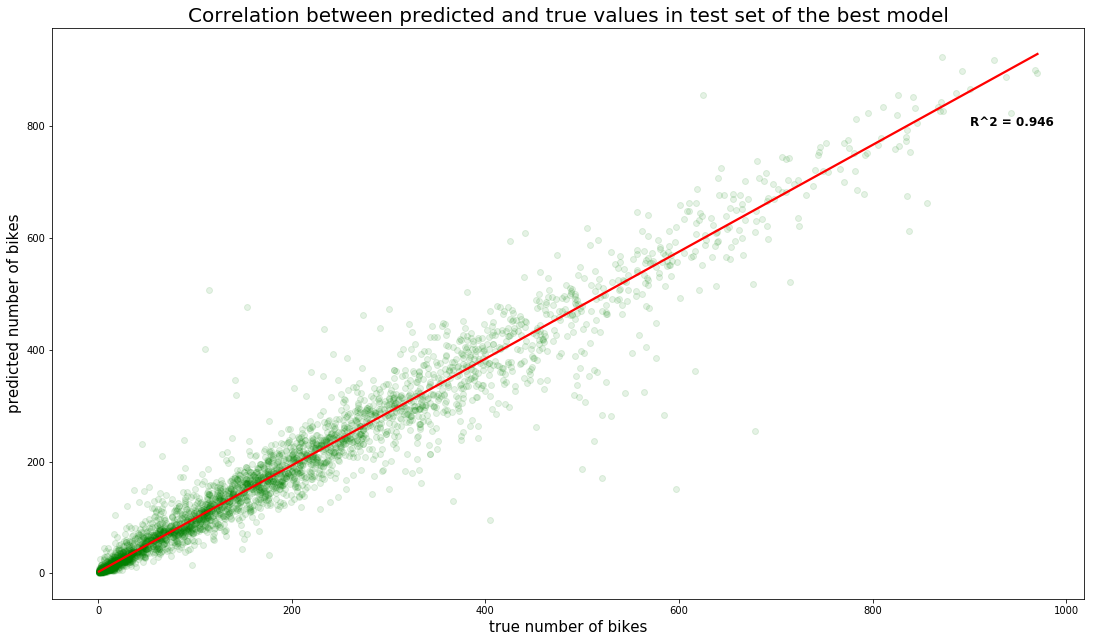

In [135]:
import seaborn as sns
pl = sns.regplot(y_test_cnt, np.exp(y_pred_cnt)-1, color="g", lowess=True, scatter_kws= {'alpha': 0.1}, line_kws={'color': 'red'})
pl.text(900, 800, "R^2 = 0.946", horizontalalignment='left', size='large', color='black', weight='bold')
pl.set_title('Correlation between predicted and true values in test set of the best model', fontdict={'fontsize':20})
pl.set_ylabel('predicted number of bikes', fontdict={'fontsize':15})
pl.set_xlabel('true number of bikes', fontdict={'fontsize':15})
pl.figure.set_size_inches(18.5, 10.5)
#sns.plt.show()


*** 

***



# Description and hypotheses 

Data shows the number of biciyles rented at the given time in Washington DC. From general experience in Paris with vélib, I can pose some hypotheses. For instance, number of bikes rented in the winter should be lower than in the summer. The causal users would be mostly turist that would rather take the bike during the day to visit the city. Other possibility for casual users are students comming from a perty in the middle of the night. Usually people bike when outside it is warm, sunny, and not too windy. However, some of the registered users, if they use the bike to go to work, they probably use it in any weather conditions. 

Online, I could find some more informations explaining bike sharing business in Washington DC:

* overview of the bikesharing in DC: https://www.citylab.com/transportation/2017/12/how-washington-dc-built-a-bike-boom/548903/
* reports and original data: https://www.capitalbikeshare.com/system-data
* general information about the climat: https://www.timeanddate.com/weather/usa/washington-dc/climate

It looks like Washington has summer that is not too warm and winter not too cold so users should be able to cycle all year round. The precipitation is fairly homogenious over the months. 

Let's learn for the data which variables seem to impact the bike rentals the most.

# Analysis

In [ ]:
# load bike_rental_hour.csv ...


## import general libs 

In [14]:
# import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Import the dataset 

In [2]:
bikes = pd.read_csv("./bike_rental_hour.csv")
bikes.shape


(17379, 17)

In [3]:
bikes.head() #see a snapshot of the data 


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
bikes.describe() #get summary of the data set 


,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [5]:
bikes.isnull().sum() #no missing values => no imputation needed => data very clean


instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [6]:
bikes.dtypes


instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

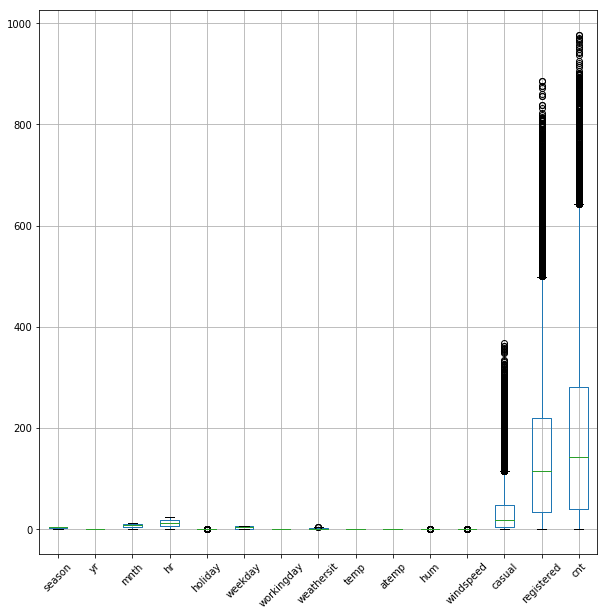

In [7]:
bikes.drop(columns='instant').boxplot(figsize=(10,10), rot=45)


**Comments: General overview**
Data is clean, no missing values, all variables are numerical or turned to numerical (no need to transform dteday as it is already split into season, year, mth, weekday/working day).

Partial feature engineering was already performed (date), holiday days, no hot-one-coding or dummies necessary.

Let's have a closer look into the distribution of variables to have an idea about trends in the data. 

## Visualize variables: spot trends

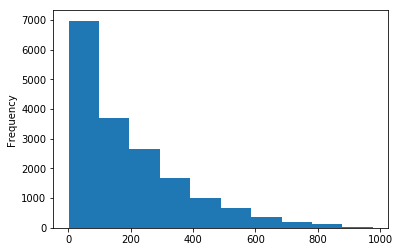

In [8]:
bikes.cnt.plot.hist() #skewed sort of poisson distribution


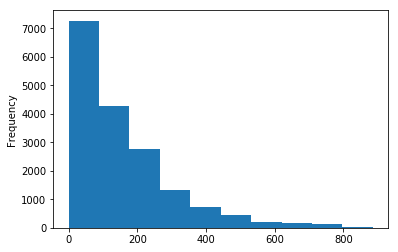

In [9]:
bikes.registered.plot.hist() #skewed


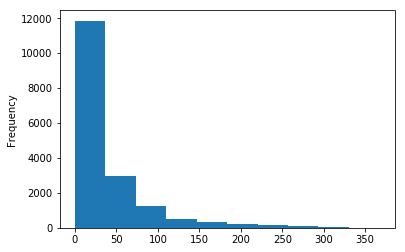

In [10]:
bikes.casual.plot.hist() #skewed


In [11]:
bikes_tps = bikes.copy()
bikes_tps['time'] = pd.to_datetime(bikes_tps.dteday)

bikes_tps['time'] +=  pd.to_timedelta(bikes_tps.hr, unit='h')

bikes_tps.head()



,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,2011-01-01 00:00:00
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,2011-01-01 01:00:00
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,2011-01-01 02:00:00
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,2011-01-01 03:00:00
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,2011-01-01 04:00:00


In [12]:
 bikes_tps.set_index('time', inplace=True)

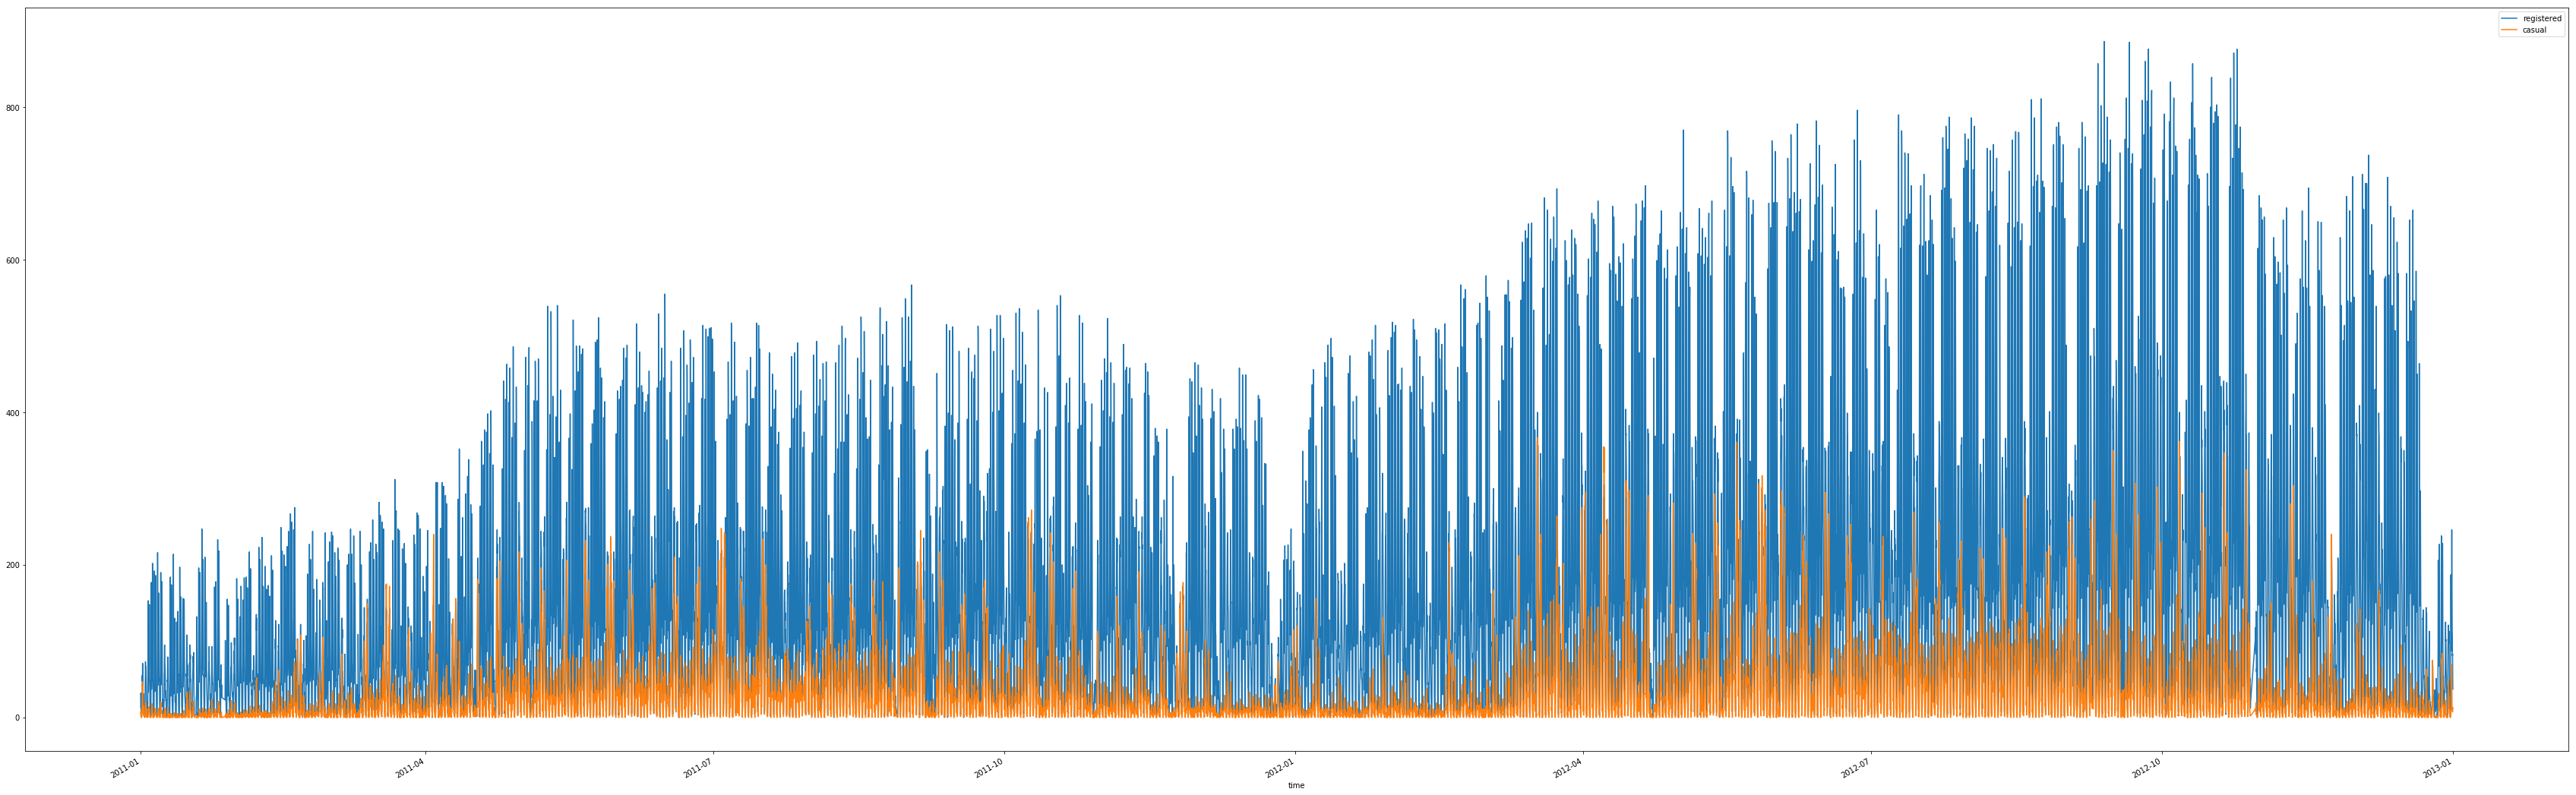

In [13]:
bikes_tps.plot(y =['registered','casual'], figsize=(60,20))


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


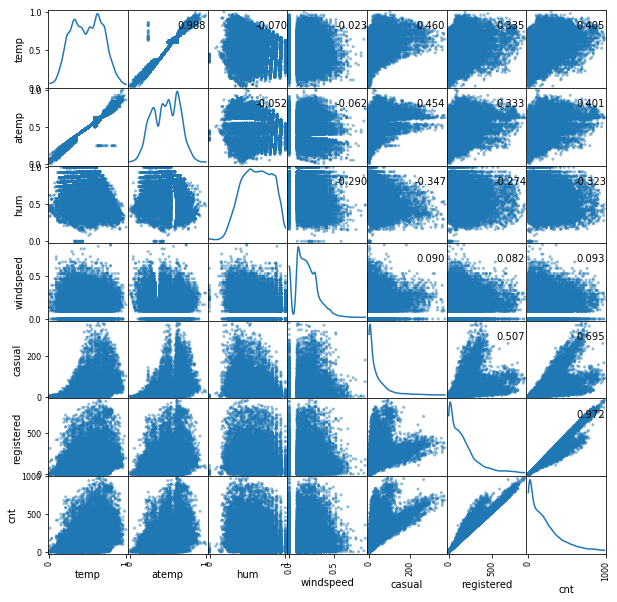

In [137]:
#plot scatter plots with correlation coefficient
from pandas.plotting import scatter_matrix
bikes_cont_vars_df = bikes.loc[:,'temp':'cnt']
scatter_pl = scatter_matrix(bikes_cont_vars_df, figsize=(10,10), diagonal='kde') #get scatter plot for all continous variables at once 
corr = bikes_cont_vars_df.corr().as_matrix()
for i, j in zip(*plt.np.triu_indices_from(scatter_pl, k=1)):
    scatter_pl[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')
#(if function used directly too much text)

**Observations: scatter plots**:

* temp is an indicator for casual renting
* registered number is dominant for the cnt 
* humidity is neg corr with casual and registered rentals
* wind has little correlation - probably a variable to exclude
* temp and atemp are strongly correlated (0.988) and one of them needs to be remoed on the future model

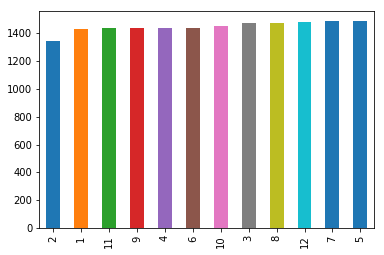

In [51]:
bikes.mnth.value_counts().sort_values().plot.bar() #representation of months is not skewed


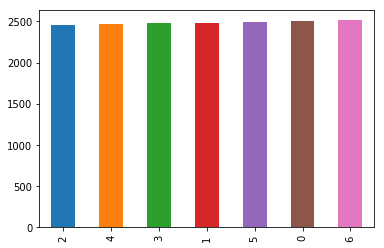

In [17]:
bikes.weekday.value_counts().sort_values().plot.bar()  #weekdays are represented evenly

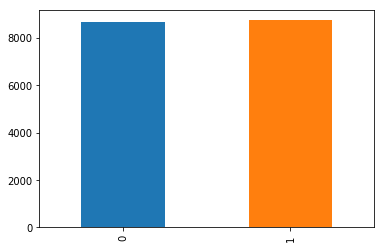

In [117]:
bikes.yr.value_counts().sort_values().plot.bar()  #weekdays are represented evenly

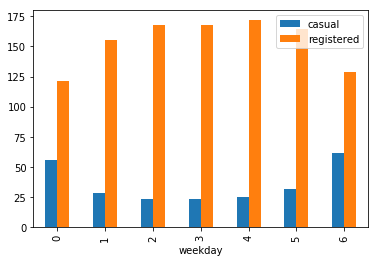

In [72]:
bikes.groupby(by='weekday').mean()[['casual', 'registered']].plot.bar() 

**Comments: rentals per weekday**

* days 0 & 6 => Sunday & Saturday, 1 Monday etc.
* more registered users
* least registered rentals on Sunday, most Thursday
* least Wed. for casual, most Sat. and Sunday 

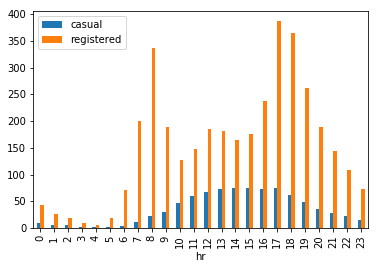

In [123]:
bikes.groupby(by='hr').mean()[['casual', 'registered']].plot.bar() 


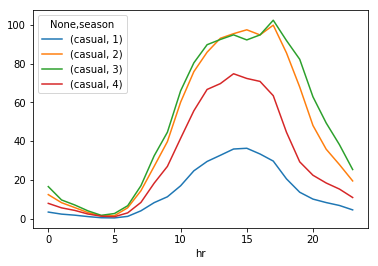

In [131]:
bikes.groupby(by=['hr','season']).mean()[['casual']].unstack().plot()#.plot.bar() 


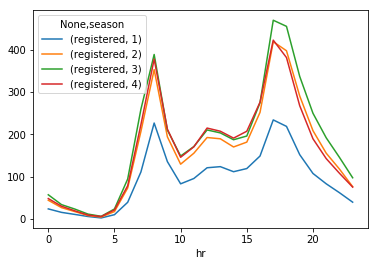

In [157]:
bikes.groupby(by=['hr','season']).mean()[['registered']].unstack().plot()#.plot.bar() 


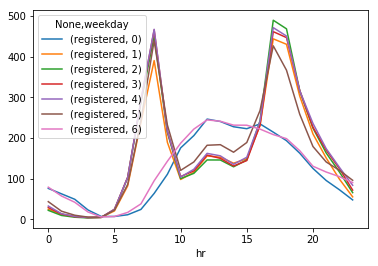

In [135]:
bikes.groupby(by=['hr','weekday']).mean()[['registered']].unstack().plot()


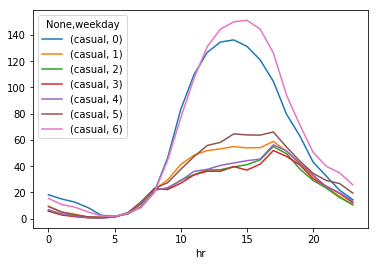

In [136]:
bikes.groupby(by=['hr','weekday']).mean()[['casual']].unstack().plot()


**Comments: rentals per weekday**

* casual highest demand is at 3PM (in the middle of the day)
* rental highest demand has 2 peaks, in the morning and in the evening (8 AM and 5-6 PM)
* renting hours are not affected by seasons
* renting hours are affected by weekday for registred members (interaction varaible can be helpful for the futur model)

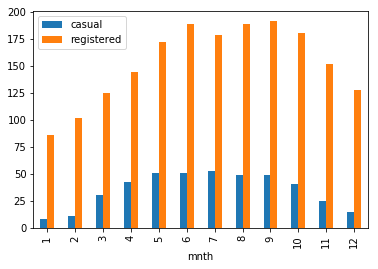

In [77]:
bikes.groupby(by='mnth').mean()[['casual', 'registered']].plot.bar() 


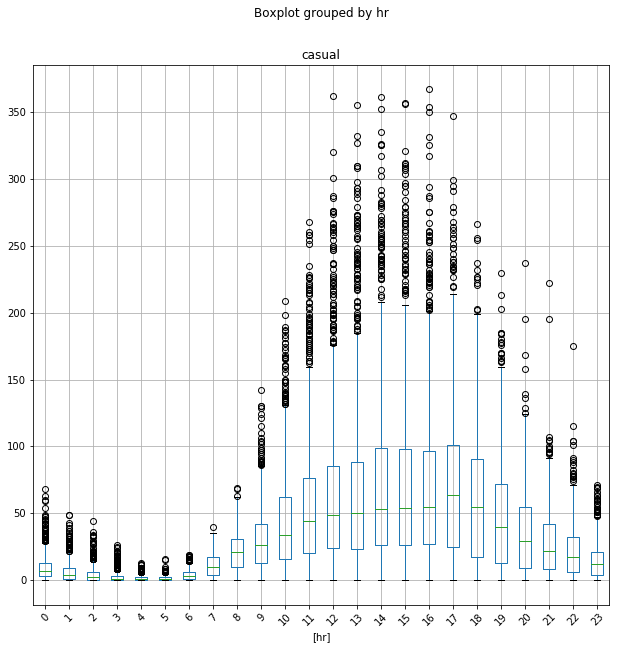

In [151]:
bikes[['casual', 'hr']].boxplot(figsize=(10,10),by='hr', rot=45)


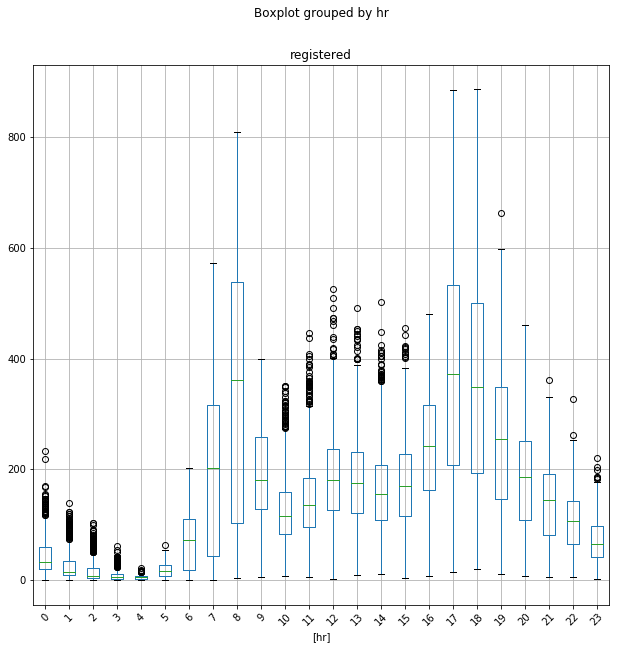

In [152]:
bikes[['registered', 'hr']].boxplot(figsize=(10,10),by='hr', rot=45)


**Comments: rentals per month**

* most registered users June, least Jan => it goes up till summer then down
* similar for causal
* casual have a lot of outliers 

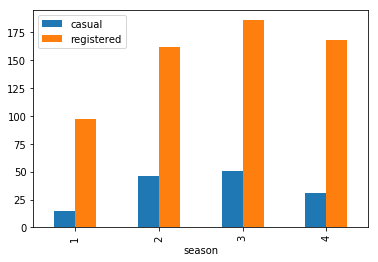

In [79]:
bikes.groupby(by='season').mean()[['casual', 'registered']].plot.bar() 


**Comments: rentals per season**

reflects trends for months, probably will make sense to use this variable rather than month

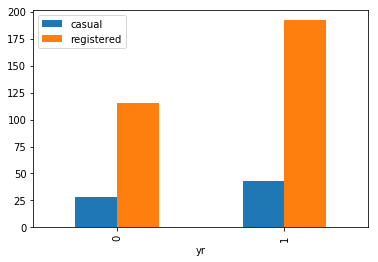

In [80]:
bikes.groupby(by='yr').mean()[['casual', 'registered']].plot.bar() 


In [116]:
diff_1_0_y = bikes.groupby(by='yr').mean()[['casual', 'registered']].iloc[1,]- bikes.groupby(by='yr').mean()[['casual', 'registered']].iloc[0,]
c= (diff_1_0_y/bikes.groupby(by='yr').mean()[['casual', 'registered']].iloc[0,]).casual
r = (diff_1_0_y/bikes.groupby(by='yr').mean()[['casual', 'registered']].iloc[0,]).registered
(diff_1_0_y/bikes.groupby(by='yr').mean()[['casual', 'registered']].iloc[0,])

casual        0.492269
registered    0.666639
dtype: float64

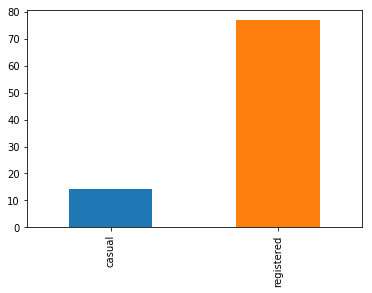

In [103]:
diff_1_0_y.plot.bar()

**Comments: rentals per season**

both causal and registered increased
casual increased by  nearly 50% and registered  by 66%

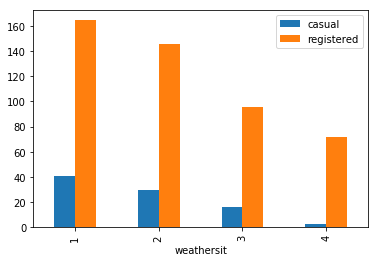

In [133]:
bikes.groupby(by='weathersit').mean()[['casual', 'registered']].plot.bar() 


**Comments: rentals depending on weather situation**

Weather goes from 1-4 (probably from good to bad), wich is linary correlated with decrease of users

### check outliers

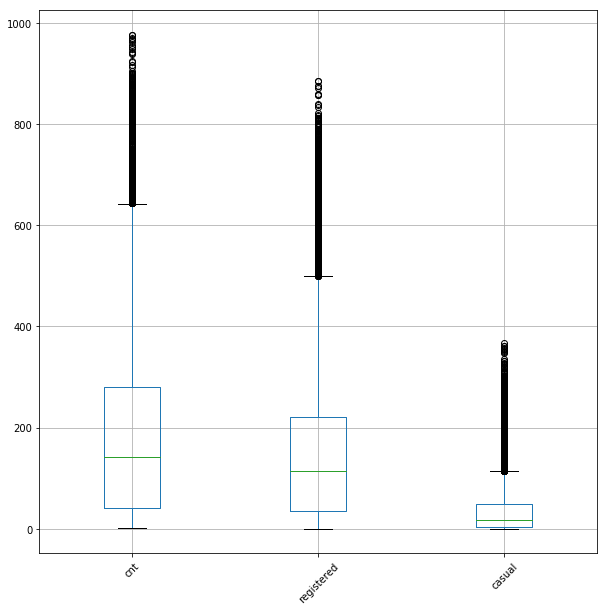

In [144]:
bikes[['cnt', 'registered', 'casual']].boxplot(figsize=(10,10), rot=45)


A lot of outliers can be observed for both registered and casual. It could be observed also from `_describe()`table (quantiles) and from the previous boxplots.

outliers can bias a regression model (grabage in, garbage out) but let's build a first model without removing any data (to have the baseline performance) 



In [ ]:
#dailyDataWithoutOutliers = dailyData[np.abs(dailyData["count"]-dailyData["count"].mean())<=(3*dailyData["count"].std())]

# Prediction

In [ ]:
# don't forget to split the data into training and testing sets ..


## test and train

any transformations applied to dataset should apply to the whole dataset and then split to test and train. I will build first baseline regression model without many modifications

**Define colums that should be used as predictors**

1. instant, dteday - useless for the model
2. cnt, registered and casual must be removed as they are target
3. atmp will be removed as it is highly correlated with tmp and its corellation with target is lower 

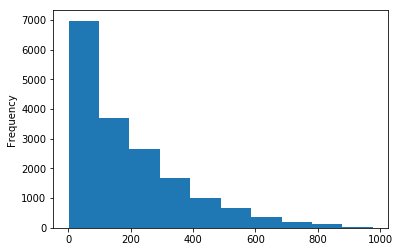

In [160]:
bikes['cnt'].plot.hist()

In [161]:
bikes['cnt'].shape

(17379,)

In [39]:
from sklearn.model_selection import train_test_split

# define bins for stratification
bins = np.linspace(0, 17379, 100)
# Save your Y values in a new ndarray,
# broken down by the bins created above.
y_binned = np.digitize(bikes['cnt'], bins)


#split
X_train, X_test, y_train, y_test = train_test_split(bikes.drop(
                                                    columns = ['instant','dteday','cnt','atemp',
                                                               'registered', 'casual']), #X
                                                    bikes['cnt'], #Y
                                                    random_state=0, #seed
                                                    stratify=y_binned, #have a representative sample
                                                    test_size=0.2) #using 20% for test

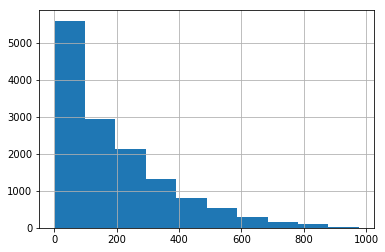

In [169]:
y_train.hist()

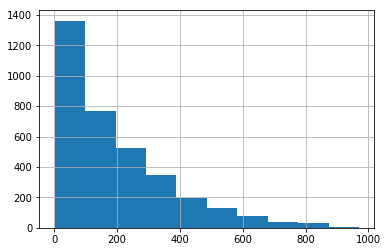

In [170]:
y_test.hist() #looks ok

In [40]:
from sklearn import linear_model
lin_reg = linear_model.LinearRegression() #import

In [43]:
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [42]:
#supress the bug warning
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")


In [44]:
# The coefficients
print('Coefficients: \n', lin_reg.coef_)


Coefficients: 
 [  21.06860027   79.57638575   -0.43544354    7.69852621  -24.00734067
    2.29545558    2.54056688   -4.90722381  288.16179833 -196.65963833
   33.85988929]


In [45]:
lin_reg.score(X_test, y_test) #R^2 - could be better

0.3708506249595106

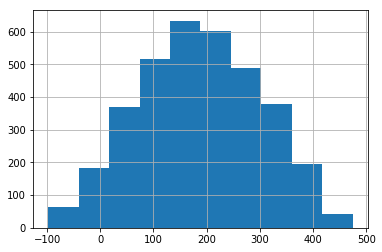

In [185]:
pd.Series(lin_reg.predict(X_test)).hist() #we get negative values (bad! a constrain should be added?)

In [197]:
y_pred = lin_reg.predict(X_test)

y_pred.dtype

dtype('int64')

In [193]:
y_test.dtype

dtype('int64')

In [131]:
reg_metric(y_test, y_pred)

explained variance :0.006380303917291719
MAE :185.98552794455537
MSE : 67321.41382309434
MeDAE :139.88207942054962
R^2 : -1.0420559536105132


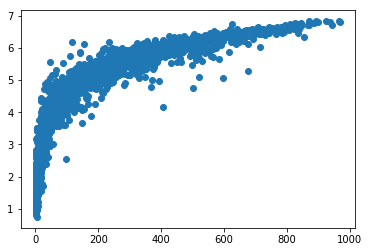

In [119]:
plt.scatter(y_test, y_pred) 


**Comments**

1. The predicted values are negative and not intiger
2. R^2 is negative (!!!!)

**Result** Input/model is not ok

A possible solution : change the output varaible (though **log(x+1)**) => distribution closer to gaussian, better perf. of the agorithms should help with the negative values

*don't forget to exp(x) solution* 


In [47]:
y_train_log, y_test_log = np.log1p(y_train), np.log1p(y_test)

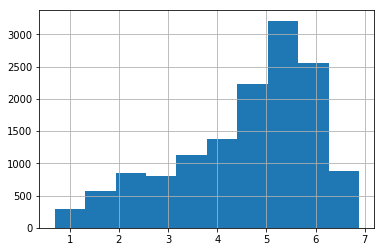

In [245]:
y_train_log.hist()

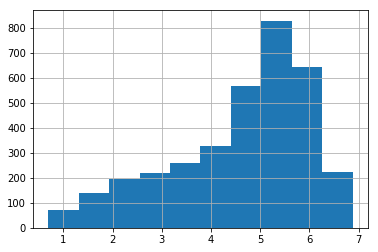

In [246]:
y_test_log.hist()

In [77]:
lin_reg.fit(X_train, y_train_log)
y_pred = lin_reg.predict(X_test)
reg_metric(y_test_log, y_pred)

 explained variance :0.4829923352
 MAE :0.8019128419
 MSE :1.0307272298
 MeDAE :0.6601368971
 R^2 :0.4824905465



In [78]:
#when applied to actual values 
reg_metric(np.exp(y_test_log)-1, np.exp(y_pred)-1)


 explained variance :0.2272520807
 MAE :109.1473333598
 MSE :27282.9466692356
 MeDAE :59.8499875905
 R^2 :0.1724281991



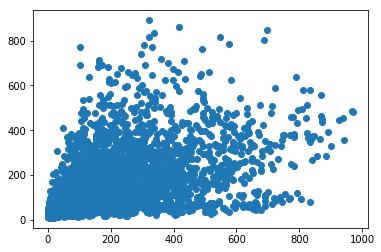

In [334]:
plt.scatter(np.exp(y_test_log)-1, np.exp(y_pred)-1)

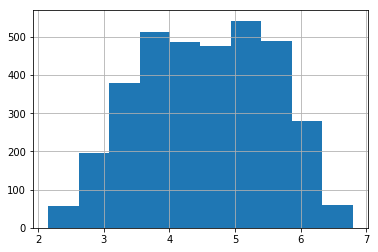

In [250]:
pd.Series(y_pred).hist() #no more neg values

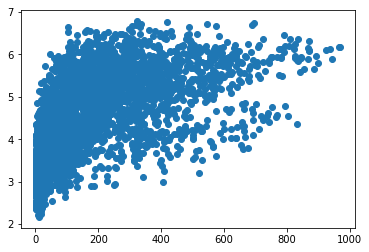

In [251]:
plt.scatter(y_test, y_pred) 

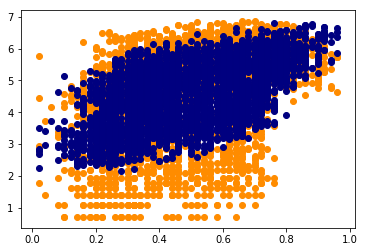

In [513]:

plt.scatter(X_test['temp'], y_test_log, color='darkorange', label='data')
plt.scatter(X_test['temp'], y_pred, color='navy',  label='RBF model')


**Comments** 

Logging of the output varaible was necessary, R^2 is better, error can be minimized

## Statistical parenthesis

Linear models can be analyzed in more statistical way, library `statsmodels` proposes a variety of models and facilitate computation of metric. I will use it to see if there are variables that are not important in the model based on the P. value, and the standard errror. I will verify the residuals.

In [474]:
#I could use it on all data but let's pretend I don't have the test part (shouldn't change much)
import statsmodels.formula.api as sm 
all_columns = "cnt~"+"+".join(X_train.columns.values)
Xy_train_log= X_train.assign(cnt = y_train_log)
ols_reg_log = sm.ols(all_columns,Xy_train_log).fit()#I know it looks more like R but it is to better understand the regression and feature importance 
ols_reg = sm.ols(all_columns,Xy_train).fit()

In [475]:
ols_reg_log.params


Intercept     2.669218
season        0.161447
yr            0.415531
mnth         -0.002985
hr            0.097241
holiday      -0.180964
weekday       0.019935
workingday   -0.052054
weathersit   -0.010726
temp          1.982363
hum          -1.368022
windspeed     0.274549
dtype: float64

In [476]:
ols_reg_log.summary() # from the summary it looks like mnth and weathersit are not usefull features 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     1188.
Date:                Wed, 22 Aug 2018   Prob (F-statistic):               0.00
Time:                        10:42:14   Log-Likelihood:                -19987.
No. Observations:               13903   AIC:                         4.000e+04
Df Residuals:                   13891   BIC:                         4.009e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6692      0.055     48.754      0.000       2.562       2.777
season         0.1614      0.015     10.930      0.000       0.132       0.190
yr             0.4155      0.017     23.893      0.000       0.381       0.450
mnth          -0.0030      0.005     -0.647      0.517      -0.012       0.006
hr             0.0972      0.001     73.550      0.000       0.095       0.100
holiday       -0.1810      0.055     -3.313      0.001      -0.288      -0.074
weekday        0.0199      0.004      4.601      0.000       0.011       0.028
workingday    -0.0521      0.019     -2.712      0.007      -0.090      -0.014
weathersit    -0.0107      0.015     -0.701      0.484      -0.041       0.019
temp           1.9824      0.048     40.964      0.000       1.888       2.077
hum           -1.3680      0.055    -24.719      0.000      -1.477      -1.260
windspeed      0.2745      0.076      3.626      0.000       0.126       0.423
==============================================================================
Omnibus:                      161.968   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              166.665
Skew:                          -0.264   Prob(JB):                     6.44e-37
Kurtosis:                       2.903   Cond. No.                         153.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [477]:
ols_reg.summary() # from the summary it looks like mnth and weathersit are not usefull features 


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     813.5
Date:                Wed, 22 Aug 2018   Prob (F-statistic):               0.00
Time:                        10:42:31   Log-Likelihood:                -88571.
No. Observations:               13903   AIC:                         1.772e+05
Df Residuals:                   13891   BIC:                         1.773e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -17.1555      7.599     -2.257      0.024     -32.051      -2.260
season        21.0686      2.050     10.276      0.000      17.050      25.087
yr            79.5764      2.414     32.965      0.000      74.845      84.308
mnth          -0.4354      0.640     -0.680      0.496      -1.690       0.819
hr             7.6985      0.184     41.950      0.000       7.339       8.058
holiday      -24.0073      7.581     -3.167      0.002     -38.868      -9.147
weekday        2.2955      0.601      3.817      0.000       1.117       3.474
workingday     2.5406      2.664      0.954      0.340      -2.681       7.762
weathersit    -4.9072      2.125     -2.309      0.021      -9.073      -0.742
temp         288.1618      6.717     42.899      0.000     274.995     301.328
hum         -196.6596      7.682    -25.601      0.000    -211.717    -181.602
windspeed     33.8599     10.509      3.222      0.001      13.261      54.459
==============================================================================
Omnibus:                     2697.693   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5203.621
Skew:                           1.187   Prob(JB):                         0.00
Kurtosis:                       4.829   Cond. No.                         153.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

*Disclamer* 

statisitical graphs produced thanks to the post: https://medium.com/@emredjan/emulating-r-regression-plots-in-python-43741952c034

Text(0.5,0,'Residuals')

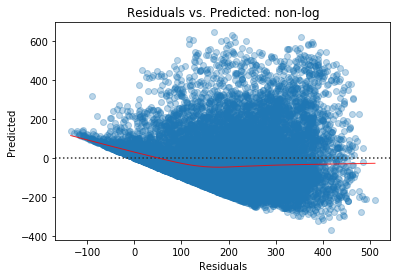

In [493]:
#plt.scatter( ols_reg.fittedvalues, ols_reg.resid, alpha=0.2)
import seaborn as sns
residuals_plot = sns.residplot(ols_reg.fittedvalues, 'cnt', data=Xy_train, 
                          lowess=True, 
                          scatter_kws={'alpha': 0.3}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
residuals_plot.set_title("Residuals vs. Predicted: non-log")
residuals_plot.set_ylabel('Predicted')
residuals_plot.set_xlabel('Residuals')


Text(0.5,0,'Residuals')

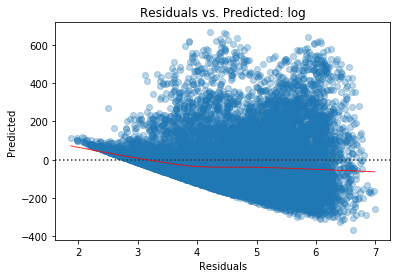

In [494]:
#plt.scatter( ols_reg.fittedvalues, ols_reg.resid, alpha=0.2)
import seaborn as sns
residuals_plot = sns.residplot(ols_reg_log.fittedvalues, 'cnt', data=Xy_train, 
                          lowess=True, 
                          scatter_kws={'alpha': 0.3}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
residuals_plot.set_title("Residuals vs. Predicted: log")
residuals_plot.set_ylabel('Predicted')
residuals_plot.set_xlabel('Residuals')


Text(0.5,1,'QQplot: non-log')

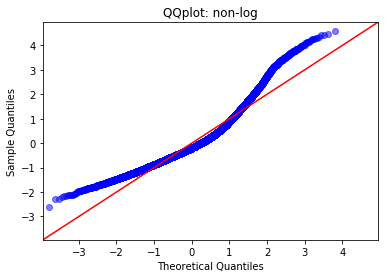

In [491]:
from statsmodels.graphics.gofplots import ProbPlot
qq_plot = ProbPlot(ols_reg.get_influence().resid_studentized_internal)
qq_plot2 = qq_plot.qqplot(line='45', alpha=0.5, color='blue', lw=1)
qq_plot2.axes[0].set_title('QQplot: non-log')


Text(0.5,1,'QQplot: log')

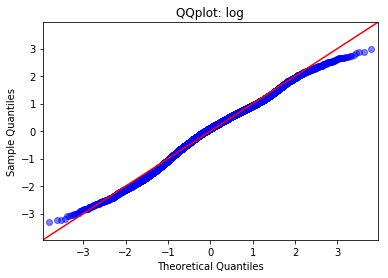

In [492]:
from statsmodels.graphics.gofplots import ProbPlot
qq_plot = ProbPlot(ols_reg_log.get_influence().resid_studentized_internal)
qq_plot2 = qq_plot.qqplot(line='45', alpha=0.5, color='blue', lw=1)
qq_plot2.axes[0].set_title('QQplot: log')


**Comments**

QQplot shows how well the distribution of residuals fit the normal distribution. This plots the standardized (z-score) residuals against the theoretical normal quantiles. Anything quite off the diagonal lines may be a concern for further investigation.

QQ plots here looks ok, not many pmoints are off diagonal in the log response model, the situation is bad in the non-log model => another reason to log the response varaible

Text(0,0.5,'Standardized Residuals')

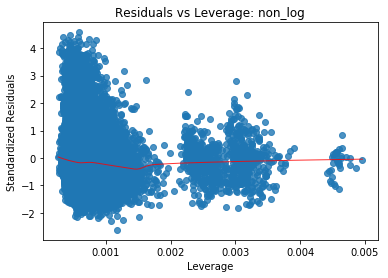

In [484]:
laverage_pl = sns.regplot(ols_reg.get_influence().hat_matrix_diag, ols_reg.get_influence().resid_studentized_internal, 
            scatter=True, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

laverage_pl.set_title('Residuals vs Leverage: non_log')
laverage_pl.set_xlabel('Leverage')
laverage_pl.set_ylabel('Standardized Residuals')


Text(0,0.5,'Standardized Residuals')

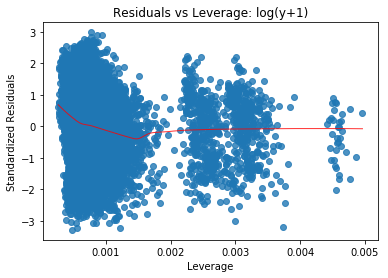

In [483]:
laverage_pl = sns.regplot(ols_reg_log.get_influence().hat_matrix_diag, ols_reg_log.get_influence().resid_studentized_internal, 
            scatter=True, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

laverage_pl.set_title('Residuals vs Leverage: log(y+1)')
laverage_pl.set_xlabel('Leverage')
laverage_pl.set_ylabel('Standardized Residuals')


**Comments**

The 'Residuals vs Leverage' allows study the impact of outliers. It looks like there is a lot of outliers that impact the regression that is similar for log and non-log models.

#### remove features 

In [319]:
all_columns_red1 = "cnt~"+"+".join(X_train.drop(columns=['weathersit', 'mnth']).columns.values)
Xy_train= X_train.assign(cnt = y_train_log)
ols_reg = sm.ols(all_columns_red1,Xy_train).fit()
ols_reg.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     1452.
Date:                Tue, 21 Aug 2018   Prob (F-statistic):               0.00
Time:                        23:26:04   Log-Likelihood:                -19987.
No. Observations:               13903   AIC:                         3.999e+04
Df Residuals:                   13893   BIC:                         4.007e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6671      0.055     48.824      0.000       2.560       2.774
season         0.1539      0.008     18.268      0.000       0.137       0.170
yr             0.4151      0.017     23.879      0.000       0.381       0.449
hr             0.0971      0.001     74.022      0.000       0.095       0.100
holiday       -0.1823      0.055     -3.342      0.001      -0.289      -0.075
weekday        0.0198      0.004      4.575      0.000       0.011       0.028
workingday    -0.0526      0.019     -2.741      0.006      -0.090      -0.015
temp           1.9880      0.048     41.406      0.000       1.894       2.082
hum           -1.3878      0.049    -28.237      0.000      -1.484      -1.291
windspeed      0.2664      0.075      3.565      0.000       0.120       0.413
==============================================================================
Omnibus:                      160.431   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              165.116
Skew:                          -0.263   Prob(JB):                     1.40e-36
Kurtosis:                       2.906   Cond. No.                         137.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Comment**

The R^2 didn't improuve but didn't decrease neither after removal of 'weathersit' and 'mnth'

'hr' remains the most important feature of the model


## Regression models in sci-kit learn

Let's try different regression models with default params

In [68]:
from sklearn.model_selection import train_test_split

# define bins for stratification
bins = np.linspace(0, 17379, 100)
# Save your Y values in a new ndarray,
# broken down by the bins created above.
y_binned = np.digitize(bikes['cnt'], bins)


#split
X_train, X_test, y_train, y_test = train_test_split(bikes.drop(
                                                    columns = ['instant','dteday','cnt','atemp',
                                                               'registered', 'casual']), #X
                                                    bikes['cnt'], #Y
                                                    random_state=123, #seed
                                                    stratify=y_binned, #have a representative sample
                                                    test_size=0.2) #using 20% for test
y_train_log, y_test_log = np.log1p(y_train), np.log1p(y_test) #get log

In [5]:
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn import neighbors
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor

regression_models = [('LinearRegression', linear_model.LinearRegression()), #baseline
                     ('Lasso', linear_model.Lasso()), #regularization L1
                      ('Ridge', linear_model.Ridge()),#regularization L2
                     ('RANSAC', linear_model.RANSACRegressor()), #to cope with outliers
                       ('SVR_rbf', SVR(kernel='rbf', C=1e3, gamma=0.1)), #SVR 
                       ('SVR_lin', SVR(kernel='linear', C=1e3)),#SVR 
                       ('SVR_poly', SVR(kernel='poly', C=1e3, degree=2)),#SVR 
                       ('KNN_uniform', neighbors.KNeighborsRegressor(5, weights="uniform")), #Knn
                       ('KNN_distance', neighbors.KNeighborsRegressor(5, weights="distance")), #kKn
                       ('tree', tree.DecisionTreeRegressor()), #trees
                       ('Random_forest', RandomForestRegressor()), #random forest
                       ('GB', GradientBoostingRegressor()), #boosted trees
                       ('XBG', XGBRegressor()) #kaggle champion xgb
                       ]
# evaluate each model in turn
names = []
dict_method_score = {}
scoring = 'MSE'

print("Method: MSE")

for name, model in regression_models:
    model.random_state = 123
    model.fit(X_train, y_train_log)
    y_pred = model.predict(X_test)
    dict_method_score[name]= mean_squared_error(y_test_log, y_pred)
    print("{:s}: {:.3f}".format(name, dict_method_score[name]))



/usr/local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


Method: MSE
LinearRegression: 1.031
Lasso: 1.372
Ridge: 1.031
RANSAC: 1.626
SVR_rbf: 0.105
SVR_lin: 1.038
SVR_poly: 0.957
KNN_uniform: 0.130
KNN_distance: 0.128
tree: 0.202
Random_forest: 0.111
GB: 0.164
XBG: 0.164


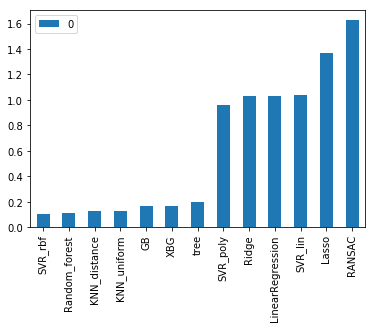

In [63]:
pd.DataFrame.from_dict(dict_method_score, orient= 'index').sort_values(0).plot.bar()

Let's run again the Random Forest to look inside 

In [205]:
rf = RandomForestRegressor(random_state=123)
rf.fit(X_train, y_train_log)
y_pred = rf.predict(X_test)

reg_metric(y_test_log, y_pred) 
    
##MSE is lower than before- maybe data was resampled

explained variance :0.9452263079658352
MAE :0.22265747252597257
MSE : 0.11081026365786212
MeDAE :0.14181243366712604
R^2 : 0.9451786301166464


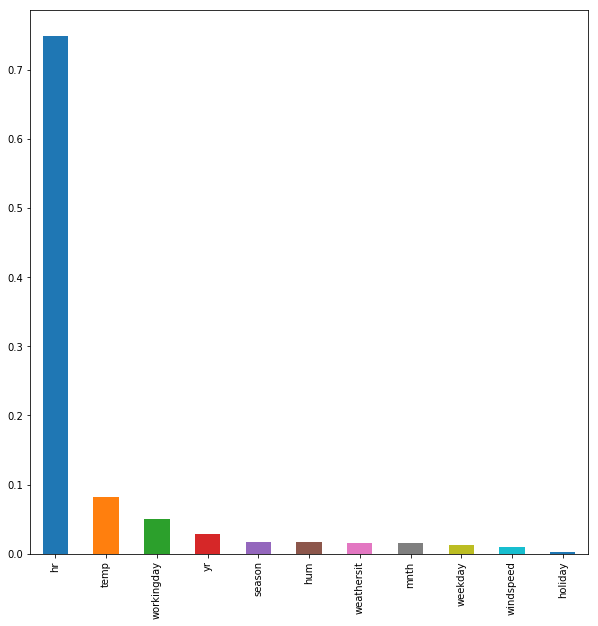

In [206]:
pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False).plot.bar(figsize=(10,10))

In [91]:
rmsle(y_test_log, y_pred)

0.31168807833876244

Method: MSE
LinearRegression: 1.031
Lasso: 1.372
Ridge: 1.031
RANSAC: 1.626
SVR_rbf: 0.105
SVR_lin: 1.038
SVR_poly: 0.957
KNN_uniform: 0.130
KNN_distance: 0.128
tree: 0.202
Random_forest: 0.111
GB: 0.164
XBG: 0.164

**Comments**

SVR with "rbf" non linear kernel got the lowest MSE, the next models were random forest and knn regressions. 
I will user random forest as it is much faster than SVR for the experiments with feature engineering. 

Clearly the problem requires non-linear methods. 

## Reshaping data 

I focused on `MSE` metric and try to observe if it deceases with changes I make, to remeber the baseline MSE (of the log model) was **1.19016** then the score for random forest with default parameters was **0.111 - 0.109**

#### strategy 1: predict separately registered & casual

##### Build two separate models

In [137]:
test_separately(RandomForestRegressor(random_state=123))

### registered users model only

explained variance :0.9452653153751096
MAE :0.2159885741069771
MSE : 0.10656009340036587
MeDAE :0.13716063992263328
R^2 : 0.9452637845959052
################################

### registered users model only

explained variance :0.878204240620797
MAE :0.3791856429968254
MSE : 0.26307968796182696
MeDAE :0.2781843597506215
R^2 : 0.8781898986802478
################################

### Final metrics for cnt

explained variance :0.9486394374037312
MAE :0.21161731820585575
MSE : 0.10232350183758047
MeDAE :0.13090879392305532
R^2 : 0.9486252250073292
################################



**Comments**

 The MSE for registered users is more challenging than for casual, globally, there is no a gudge improvement but a slight one. This is an idea that can be included in the final model

#### strategy 2: normalize data

In [ ]:
from sklearn.model_selection import train_test_split

# define bins for stratification
bins = np.linspace(0, 17379, 100)
# Save your Y values in a new ndarray,
# broken down by the bins created above.
y_binned = np.digitize(bikes['cnt'], bins)

bikes


#split
X_train, X_test, y_train, y_test = train_test_split(bikes.drop(
                                                    columns = ['instant','dteday','cnt','atemp',
                                                               'registered', 'casual']), #X
                                                    bikes['cnt'], #Y
                                                    random_state=123, #seed
                                                    stratify=y_binned, #have a representative sample
                                                    test_size=0.2) #using 20% for test
y_train_log, y_test_log = np.log1p(y_train), np.log1p(y_test) #get log


In [140]:
from sklearn import preprocessing

scalers = [('Standard', preprocessing.StandardScaler()), 
            ('MinMax', preprocessing.MinMaxScaler()),
           ('Robust', preprocessing.RobustScaler())]
            
# evaluate each model in turn
dict_method_score = {}
scoring = 'MSE'

print("Method: MSE")
scaler = preprocessing.StandardScaler()
for name, scaler in scalers:
    model = RandomForestRegressor(random_state=123)
    X_train_sc = scaler.fit_transform(X_train)
    model.fit(X_train_sc, y_train_log)
    X_test_sc = scaler.transform(X_test)
    y_pred = model.predict(X_test_sc)
    dict_method_score[name]= mean_squared_error(y_test_log, y_pred)
    print("{:s}: {:.3f}".format(name, dict_method_score[name]))

model = RandomForestRegressor(random_state=123)
model.fit(X_train, y_train_log)
y_pred = model.predict(X_test)
dict_method_score["No"]= mean_squared_error(y_test_log, y_pred)
print("{:s}: {:.3f}".format("No", dict_method_score["No"]))



Method: MSE
Standard: 0.110
MinMax: 0.109
Robust: 0.109
No: 0.110


**Comments**

No (very little) efect of scaling on the score

#### strategy 3: remove outliers

In [142]:
bikes_no_outliers_sd2 = bikes[np.abs(bikes["cnt"]-bikes["cnt"].mean())<=(2*bikes["cnt"].std())] 

In [143]:
bikes_no_outliers_sd3 = bikes[np.abs(bikes["cnt"]-bikes["cnt"].mean())<=(3*bikes["cnt"].std())] 

In [147]:
bikes_no_outliers_sd4 = bikes[np.abs(bikes["cnt"]-bikes["cnt"].mean())<=(4*bikes["cnt"].std())] 

In [173]:
test_outliers(2)

explained variance :0.9389468920566344
MAE :0.2437197927968068
MSE : 0.12371011217658591
MeDAE :0.16424225319855124
R^2 : 0.9387966638281472


In [174]:
test_outliers(3)

explained variance :0.9449888276549577
MAE :0.22580151064900192
MSE : 0.11119394084821145
MeDAE :0.146676662594158
R^2 : 0.9449888127795729


In [175]:
test_outliers(4)

explained variance :0.9443717832187173
MAE :0.22335032936798305
MSE : 0.11254838449511687
MeDAE :0.13832202370240498
R^2 : 0.9443187263299782


**Comments** 

It looks like removal of the outliers does not improves the scores

#### strategy 4: check interactions of features

In [243]:
from sklearn.preprocessing import PolynomialFeatures
inter = PolynomialFeatures(interaction_only=True)

# define bins for stratification
bins = np.linspace(0, 17379, 100)
# Save your Y values in a new ndarray,
# broken down by the bins created above.
y_binned = np.digitize(bikes['cnt'], bins)


#split
X_train, X_test, y_train, y_test = train_test_split(bikes.drop(
                                            columns = ['instant','dteday','cnt','atemp',
                                                       'registered', 'casual']), #X
                                            bikes['cnt'], #Y
                                            random_state=123, #seed
                                            stratify=y_binned, #have a representative sample
                                            test_size=0.2) #using 20% for test

y_train_log, y_test_log = np.log1p(y_train), np.log1p(y_test) #get log
X_train_inter = inter.fit_transform(X_train)
X_test_inter = inter.fit_transform(X_test)
rf = RandomForestRegressor(random_state=123)
rf.fit(X_train_inter, y_train_log)
y_pred = rf.predict(X_test_inter)

reg_metric(y_test_log, y_pred) 



explained variance :0.9421392723547451
MAE :0.22746547931116617
MSE : 0.11696564511389773
MeDAE :0.14389864054481594
R^2 : 0.94213336668675


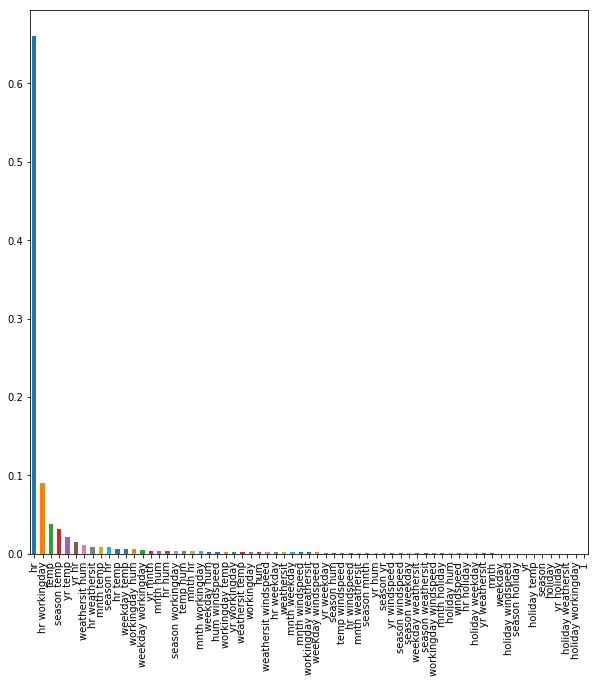

In [235]:
pd.Series(rf.feature_importances_, index=inter.get_feature_names(X_train.columns)).sort_values(ascending=False).plot.bar(figsize=(10,10))

In [256]:
nw_feat = pd.Series(rf.feature_importances_, index=inter.get_feature_names(X_train.columns)).sort_values(ascending=False).iloc[[1,3],].index


In [257]:
from sklearn.preprocessing import PolynomialFeatures
inter = PolynomialFeatures(interaction_only=True)

# define bins for stratification
bins = np.linspace(0, 17379, 100)
# Save your Y values in a new ndarray,
# broken down by the bins created above.
y_binned = np.digitize(bikes['cnt'], bins)


#split
X_train, X_test, y_train, y_test = train_test_split(bikes.drop(
                                            columns = ['instant','dteday','cnt','atemp',
                                                       'registered', 'casual']), #X
                                            bikes['cnt'], #Y
                                            random_state=123, #seed
                                            stratify=y_binned, #have a representative sample
                                            test_size=0.2) #using 20% for test

y_train_log, y_test_log = np.log1p(y_train), np.log1p(y_test) #get log
X_train_inter = inter.fit_transform(X_train)
X_test_inter = inter.fit_transform(X_test)
X_train_nw = pd.DataFrame(X_train_inter, columns= inter.get_feature_names(X_train.columns))[X_train.columns.append(nw_feat)]
X_test_nw = pd.DataFrame(X_test_inter, columns= inter.get_feature_names(X_test.columns))[X_train.columns.append(nw_feat)]

rf = RandomForestRegressor(random_state=123)
rf.fit(X_train_nw, y_train_log)
y_pred = rf.predict(X_test_nw)

reg_metric(y_test_log, y_pred) 



explained variance :0.945817898276067
MAE :0.2199706790368616
MSE : 0.10962486854518562
MeDAE :0.14118326906385703
R^2 : 0.9457650828673645


#### strategy 5: change categorical encoding to hot-one encoding

In [276]:
bikes.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [277]:

pd.get_dummies(bikes, columns=['season', 'weathersit','mnth'], drop_first=True)

,instant,dteday,yr,hr,holiday,weekday,workingday,temp,atemp,hum,...,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12
0,1,2011-01-01,0,0,0,6,0,0.24,0.2879,0.81,...,0,0,0,0,0,0,0,0,0,0
1,2,2011-01-01,0,1,0,6,0,0.22,0.2727,0.80,...,0,0,0,0,0,0,0,0,0,0
2,3,2011-01-01,0,2,0,6,0,0.22,0.2727,0.80,...,0,0,0,0,0,0,0,0,0,0
3,4,2011-01-01,0,3,0,6,0,0.24,0.2879,0.75,...,0,0,0,0,0,0,0,0,0,0
4,5,2011-01-01,0,4,0,6,0,0.24,0.2879,0.75,...,0,0,0,0,0,0,0,0,0,0
5,6,2011-01-01,0,5,0,6,0,0.24,0.2576,0.75,...,0,0,0,0,0,0,0,0,0,0
6,7,2011-01-01,0,6,0,6,0,0.22,0.2727,0.80,...,0,0,0,0,0,0,0,0,0,0
7,8,2011-01-01,0,7,0,6,0,0.20,0.2576,0.86,...,0,0,0,0,0,0,0,0,0,0
8,9,2011-01-01,0,8,0,6,0,0.24,0.2879,0.75,...,0,0,0,0,0,0,0,0,0,0
9,10,2011-01-01,0,9,0,6,0,0.32,0.3485,0.76,...,0,0,0,0,0,0,0,0,0,0


In [289]:
# define bins for stratification
bins = np.linspace(0, 17379, 100)
# Save your Y values in a new ndarray,
# broken down by the bins created above.
y_binned = np.digitize(bikes['cnt'], bins)

bikes_d = pd.get_dummies(bikes, columns=['season', 'weathersit', 'mnth'], drop_first=True)

#split
X_train, X_test, y_train, y_test = train_test_split(bikes_d.drop(
                                            columns = ['instant','dteday','cnt','atemp',
                                                       'registered', 'casual']), #X
                                            bikes_d['cnt'], #Y
                                            random_state=123, #seed
                                            stratify=y_binned, #have a representative sample
                                            test_size=0.2) #using 20% for test

y_train_log, y_test_log = np.log1p(y_train), np.log1p(y_test) #get log


rf = RandomForestRegressor(random_state=123)
rf.fit(X_train, y_train_log)
y_pred = rf.predict(X_test)

reg_metric(y_test_log, y_pred) 
rmsle(y_test_log, y_pred)

explained variance :0.9412344130359733
MAE :0.22823510408928488
MSE : 0.11878958126844762
MeDAE :0.14183607540549348
R^2 : 0.9412310073269624


0.3239319278809038

**Comments**

One-hot-encoding do not decrease the MSE in this model, for the month, there is probably too many categories

#### strategy 6: change categorical encoding to bin encooding (less categories)

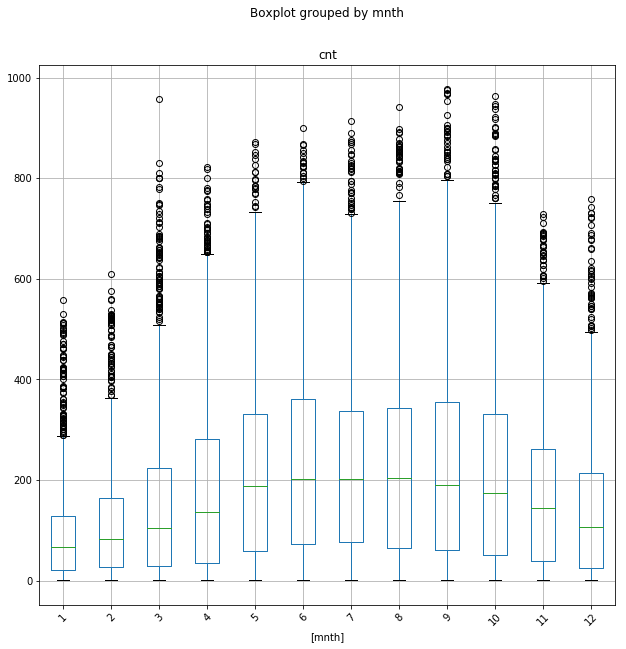

In [354]:
bikes[['cnt', 'mnth']].boxplot(figsize=(10,10),by='mnth', rot=45)

In [364]:
#(bikes['mnth'] > 10) or (bikes['mnth']< 3)
#bikes.mnth > 10
bikes.dtypes
bikes_n = bikes.assign(mnth_cat= np.zeros(bikes.shape[0]))
bikes_n['mnth_cat'] [(bikes_n['mnth'] > 10) | (bikes_n['mnth'] < 3)] = 1

bikes_n['mnth_cat'][(bikes_n['mnth'] ==3 )| (bikes_n['mnth'] ==4 ) | (bikes_n['mnth'] ==9) |(bikes_n['mnth'] ==10) ] = 2


bikes_n['mnth_cat']

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
5        1.0
6        1.0
7        1.0
8        1.0
9        1.0
10       1.0
11       1.0
12       1.0
13       1.0
14       1.0
15       1.0
16       1.0
17       1.0
18       1.0
19       1.0
20       1.0
21       1.0
22       1.0
23       1.0
24       1.0
25       1.0
26       1.0
27       1.0
28       1.0
29       1.0
        ... 
17349    1.0
17350    1.0
17351    1.0
17352    1.0
17353    1.0
17354    1.0
17355    1.0
17356    1.0
17357    1.0
17358    1.0
17359    1.0
17360    1.0
17361    1.0
17362    1.0
17363    1.0
17364    1.0
17365    1.0
17366    1.0
17367    1.0
17368    1.0
17369    1.0
17370    1.0
17371    1.0
17372    1.0
17373    1.0
17374    1.0
17375    1.0
17376    1.0
17377    1.0
17378    1.0
Name: mnth_cat, Length: 17379, dtype: float64

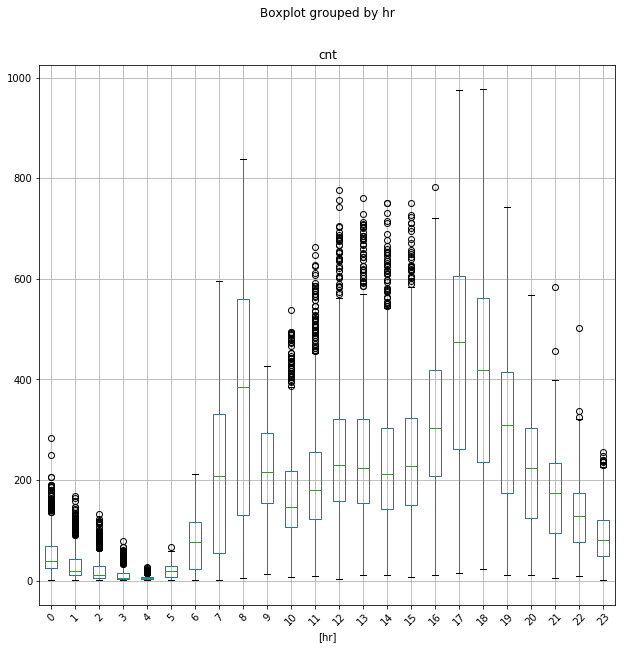

In [355]:
bikes[['cnt', 'hr']].boxplot(figsize=(10,10),by='hr', rot=45)

In [365]:
bikes_n = bikes_n.assign(hr_cat= np.zeros(bikes.shape[0]))
bikes_n['hr_cat'] [(bikes_n['hr'] < 6)] = 1
bikes_n['hr_cat'] [(bikes_n['hr'] == 6)| (bikes_n['hr'] == 22) |(bikes_n['hr'] == 23)] = 2

bikes_n['hr_cat'] [(bikes_n['hr'] == 7)| ((bikes_n['hr'] >= 9) & (bikes_n['hr'] <= 16) |((bikes_n['hr'] >= 19) & (bikes_n['hr'] <= 21) ))] = 3

bikes_n['hr_cat'] [(bikes_n['hr'] == 8)| (bikes_n['hr'] == 17) | (bikes_n['hr'] == 18)] = 4

bikes_n['hr_cat'].value_counts()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWith

3.0    8737
1.0    4276
4.0    2185
2.0    2181
Name: hr_cat, dtype: int64

In [366]:
bikes_n.columns


Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'mnth_cat', 'hr_cat'],
      dtype='object')

In [368]:
# define bins for stratification
bins = np.linspace(0, 17379, 100)
# Save your Y values in a new ndarray,
# broken down by the bins created above.
y_binned = np.digitize(bikes['cnt'], bins)

#bikes_d = pd.get_dummies(bikes, columns=['season', 'weathersit', 'mnth'], drop_first=True)

#split
X_train, X_test, y_train, y_test = train_test_split(bikes_n.drop(
                                            columns = ['instant','dteday','cnt','atemp','hr_cat','mnth',
                                                       'registered', 'casual']), #X
                                            bikes_n['cnt'], #Y
                                            random_state=123, #seed
                                            stratify=y_binned, #have a representative sample
                                            test_size=0.2) #using 20% for test

y_train_log, y_test_log = np.log1p(y_train), np.log1p(y_test) #get log


rf = RandomForestRegressor(random_state=123)
rf.fit(X_train, y_train_log)
y_pred = rf.predict(X_test)

reg_metric(y_test_log, y_pred) 
rmsle(y_test_log, y_pred)

explained variance :0.943140637140469
MAE :0.22711758135438717
MSE : 0.11493489083586012
MeDAE :0.14703367879287055
R^2 : 0.9431380455652539


0.320392908056628

In [369]:
# define bins for stratification
bins = np.linspace(0, 17379, 100)
# Save your Y values in a new ndarray,
# broken down by the bins created above.
y_binned = np.digitize(bikes['cnt'], bins)

#bikes_d = pd.get_dummies(bikes, columns=['season', 'weathersit', 'mnth'], drop_first=True)

#split
X_train, X_test, y_train, y_test = train_test_split(bikes_n.drop(
                                            columns = ['instant','dteday','cnt','atemp','hr','mnth_cat',
                                                       'registered', 'casual']), #X
                                            bikes_n['cnt'], #Y
                                            random_state=123, #seed
                                            stratify=y_binned, #have a representative sample
                                            test_size=0.2) #using 20% for test

y_train_log, y_test_log = np.log1p(y_train), np.log1p(y_test) #get log


rf = RandomForestRegressor(random_state=123)
rf.fit(X_train, y_train_log)
y_pred = rf.predict(X_test)

reg_metric(y_test_log, y_pred) 
rmsle(y_test_log, y_pred)

explained variance :0.8068043176538044
MAE :0.44352414203949736
MSE : 0.39052644517858415
MeDAE :0.3048668380070563
R^2 : 0.8067941182193246


0.5906585305727491

In [371]:
# define bins for stratification
bins = np.linspace(0, 17379, 100)
# Save your Y values in a new ndarray,
# broken down by the bins created above.
y_binned = np.digitize(bikes['cnt'], bins)

bikes_d = pd.get_dummies(bikes_n, columns=['mnth_cat'], drop_first=True)

#split
X_train, X_test, y_train, y_test = train_test_split(bikes_d.drop(
                                            columns = ['instant','dteday','cnt','atemp','hr_cat','mnth',
                                                       'registered', 'casual']), #X
                                            bikes_d['cnt'], #Y
                                            random_state=123, #seed
                                            stratify=y_binned, #have a representative sample
                                            test_size=0.2) #using 20% for test

y_train_log, y_test_log = np.log1p(y_train), np.log1p(y_test) #get log


rf = RandomForestRegressor(random_state=123)
rf.fit(X_train, y_train_log)
y_pred = rf.predict(X_test)

reg_metric(y_test_log, y_pred) 
rmsle(y_test_log, y_pred)

explained variance :0.9420067649609282
MAE :0.2296637113859781
MSE : 0.11722629601776598
MeDAE :0.15087082895129145
R^2 : 0.9420044143754776


0.3236288438389037

#### strategy 7: dimension reduction

##### PCA

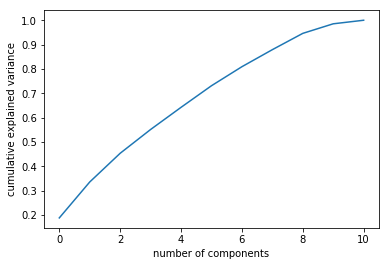

In [540]:
X_all = bikes.drop(columns = ['instant','dteday','cnt','atemp',
                                                       'registered', 'casual'])
X_sc = preprocessing.StandardScaler().fit_transform(X_all)
from sklearn.decomposition import PCA
pca = PCA(n_components=X_all.shape[1])
principalComponents = pca.fit(X_sc)
X_pca = pca.fit_transform(X_sc)
cols = ["PC%d" % x for x in range(1, (X_all.shape[1])+1)]

#print(pca.explained_variance_)
#pca = PCA().fit(digits.data)
plt.plot(np.cumsum(principalComponents.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');


In [541]:
principalDf = pd.DataFrame( data= X_pca, columns = cols)

finalDf = pd.concat([principalDf, bikes[['cnt']]], axis = 1)


In [543]:
finalDf

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,cnt
0,1.468259,2.342161,0.613500,-1.941068,2.178734,0.411658,-0.882198,-0.026945,-0.775008,-0.211819,-0.235959,16
1,1.522533,2.290932,0.615171,-1.878809,2.184536,0.419012,-0.907633,0.123246,-0.736629,-0.215343,-0.248881,40
2,1.534193,2.231703,0.605958,-1.807088,2.167385,0.417702,-0.980373,0.193063,-0.726081,-0.253621,-0.251525,32
3,1.592528,1.981892,0.586072,-1.757156,2.148880,0.406120,-1.058052,0.214022,-0.719194,-0.101735,-0.240965,13
4,1.604187,1.922663,0.576859,-1.685436,2.131729,0.404810,-1.130792,0.283840,-0.708645,-0.140013,-0.243609,1
5,1.681426,2.407096,0.369829,-0.322891,1.748863,0.911014,-0.879678,0.064737,-0.793651,0.445188,-0.257234,1
6,1.580831,1.994787,0.569103,-1.520205,2.098779,0.412461,-1.271336,0.472333,-0.683887,-0.406730,-0.262101,2
7,1.530934,2.156571,0.570526,-1.421487,2.079381,0.421691,-1.346200,0.585756,-0.673705,-0.672656,-0.278436,3
8,1.650826,1.685747,0.540004,-1.398552,2.063124,0.399570,-1.421755,0.563110,-0.666451,-0.293122,-0.254185,8
9,1.536674,1.503227,0.487357,-1.304611,1.964957,0.362801,-1.662535,0.327192,-0.755138,-0.357954,-0.214253,14


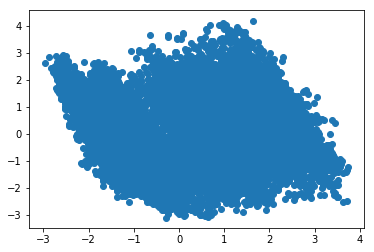

In [563]:
plt.scatter(finalDf['PC1'],finalDf['PC2']) 


In [564]:
# define bins for stratification
bins = np.linspace(0, 17379, 100)
# Save your Y values in a new ndarray,
# broken down by the bins created above.
y_binned = np.digitize(finalDf['cnt'], bins)



#split
X_train, X_test, y_train, y_test = train_test_split(finalDf.drop(
                                            columns = ['cnt']), #X
                                            finalDf['cnt'], #Y
                                            random_state=123, #seed
                                            stratify=y_binned, #have a representative sample
                                            test_size=0.2) #using 20% for test

y_train_log, y_test_log = np.log1p(y_train), np.log1p(y_test) #get log


rf = RandomForestRegressor(random_state=123)
rf.fit(X_train, y_train_log)
y_pred = rf.predict(X_test)

reg_metric(y_test_log, y_pred) 
rmsle(y_test_log, y_pred)

explained variance :0.7072486404089458
MAE :0.558169366565224
MSE : 0.5918829261878162
MeDAE :0.3993383121096379
R^2 : 0.7071766481454288


0.7342952387726953

##### ICA

In [591]:
from sklearn.decomposition import FastICA
# Compute ICA
ica = FastICA(n_components=6)
S_ = ica.fit_transform(X_all)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix


In [592]:
pd.conat([pd.DataFrame(S_), bikes['cnt']], axis= 1).corr()


,0,1,2,3,4,5,cnt
0,1.000000e+00,2.594984e-15,1.185846e-15,-1.388055e-14,-3.070330e-13,-1.443060e-14,0.100702
1,2.594984e-15,1.000000e+00,7.599715e-16,1.680866e-15,3.045731e-16,-5.255806e-16,-0.390384
2,1.185846e-15,7.599715e-16,1.000000e+00,1.202692e-15,-7.201283e-15,2.479435e-17,0.034126
3,-1.388055e-14,1.680866e-15,1.202692e-15,1.000000e+00,-3.495006e-14,-2.616146e-15,-0.256557
4,-3.070330e-13,3.045731e-16,-7.201283e-15,-3.495006e-14,1.000000e+00,-9.027868e-15,0.169490
5,-1.443060e-14,-5.255806e-16,2.479435e-17,-2.616146e-15,-9.027868e-15,1.000000e+00,-0.138973
cnt,1.007016e-01,-3.903843e-01,3.412614e-02,-2.565572e-01,1.694901e-01,-1.389726e-01,1.000000


In [606]:
bikes_ica = pd.concat([bikes, pd.DataFrame(S_).iloc[:,[1,3]]], axis=1)

In [607]:
from sklearn.model_selection import train_test_split

# define bins for stratification
bins = np.linspace(0, 17379, 100)
# Save your Y values in a new ndarray,
# broken down by the bins created above.
y_binned = np.digitize(bikes_ica['cnt'], bins)


#split
X_train, X_test, y_train, y_test = train_test_split(bikes_ica.drop(
                                                    columns = ['instant','dteday','cnt','atemp',
                                                               'registered', 'casual']), #X
                                                    bikes_ica['cnt'], #Y
                                                    random_state=123, #seed
                                                    stratify=y_binned, #have a representative sample
                                                    test_size=0.2) #using 20% for test
y_train_log, y_test_log = np.log1p(y_train), np.log1p(y_test) #get log

In [608]:
rf = RandomForestRegressor(random_state=123)
rf.fit(X_train, y_train_log)
y_pred = rf.predict(X_test)

reg_metric(y_test_log, y_pred) 
rmsle(y_test_log, y_pred)

explained variance :0.9414318157937775
MAE :0.2296017462886037
MSE : 0.11841285754127742
MeDAE :0.14493558563104258
R^2 : 0.941417384564136


0.32449068325594094

###  Parameter tuning of RandomForest

### Random search of hyperparams 

In [639]:
from sklearn.model_selection import train_test_split

# define bins for stratification
bins = np.linspace(0, 17379, 100)
# Save your Y values in a new ndarray,
# broken down by the bins created above.
y_binned = np.digitize(bikes['cnt'], bins)


#split
X_train, X_test, y_train, y_test = train_test_split(bikes.drop(
                                                    columns = ['instant','dteday','cnt','atemp',
                                                               'registered', 'casual']), #X
                                                    bikes['cnt'], #Y
                                                    random_state=123, #seed
                                                    stratify=y_binned, #have a representative sample
                                                    test_size=0.2) #using 20% for test
y_train_log, y_test_log = np.log1p(y_train), np.log1p(y_test) #get log

In [641]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf = RandomForestRegressor(random_state=123)
# Fit the random search model

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=1, random_state=123, n_jobs = -1, scoring='neg_mean_squared_error', refit=True)



In [644]:
rf_random.fit(X_train, y_train_log)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 36.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 91.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 106.2min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=123, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=123, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=1)

In [648]:
best_random = rf_random.best_estimator_

In [649]:
rf_random.best_params_

{'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 60,
 'bootstrap': True}

In [650]:
y_pred = best_random.predict(X_test)

reg_metric(y_test_log, y_pred) 
rmsle(y_test_log, y_pred)
 

explained variance :0.9502249473160028
MAE :0.21110101059629777
MSE : 0.10066833740117222
MeDAE :0.13432753716118428
R^2 : 0.9501961643440207


0.29833157010369715

### Grid search of hyperparameters

In [136]:
from sklearn.grid_search import GridSearchCV  
parameters = [{'n_estimators': np.arange(1000,3000, 50)},{'max_depth': 
np.arange(50,70, 1)}, {'min_samples_split':np.arange(2,4, 1)}]   
grid_search = GridSearchCV(estimator=best_random,
                       param_grid=parameters,
                       scoring = 'mean_squared_error',
                       cv =5,
                       n_jobs= -1) 
grid_search.fit(X_train,y_train_log)    


/usr/local/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.7/site-packages/sklea

/usr/local/lib/python3.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.7/site-packages/sklearn/m

/usr/local/lib/python3.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.7/site-packages/sklearn/m

/usr/local/lib/python3.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.7/site-packages/sklearn/m

/usr/local/lib/python3.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.7/site-packages/sklearn/m

/usr/local/lib/python3.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.7/site-packages/sklearn/m

/usr/local/lib/python3.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.7/site-packages/sklearn/m

/usr/local/lib/python3.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.7/site-packages/sklearn/m

/usr/local/lib/python3.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.7/site-packages/sklearn/m

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=60,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=1,
           oob_score=False, random_state=123, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': array([1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500,
       1550, 1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2050,
       2100, 2150, 2200, 2250, 2300, 2350, 2400, 2450, 2500, 2550, 2600,
       2650, 2700, 2750, 2800, 2850, 2900, 2950])}, {'max_depth': array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69])}, {'min_samples_split': array([2, 3])}],
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_sq

In [137]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=60,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2850, n_jobs=1,
           oob_score=False, random_state=123, verbose=0, warm_start=False)

In [138]:
best_grid = grid_search.best_estimator_

y_pred = best_grid.predict(X_test)

reg_metric(y_test_log, y_pred) 
rmsle(y_test_log, y_pred)
 

 explained variance :0.9510754304
 MAE :0.2055693345
 MSE :0.0974656409
 MeDAE :0.1278110009
 R^2 :0.9510642689



0.2936645866674621

### Test fitting to casual and registered separately

In [139]:
test_separately(best_grid)

### registered users model only

 explained variance :0.9505621549
 MAE :0.2038036503
 MSE :0.0962469755
 MeDAE :0.1272916421
 R^2 :0.9505612747

################################

### casual users model only

 explained variance :0.8890360039
 MAE :0.3632133909
 MSE :0.2396601895
 MeDAE :0.2724858133
 R^2 :0.8890335009

################################

### Final metrics for cnt

 explained variance :0.9523974640
 MAE :0.2021618230
 MSE :0.0948892130
 MeDAE :0.1247686271
 R^2 :0.9523578466

################################

### Final metrics for cnt non-log

 explained variance :0.9476059437
 MAE :24.1609624474
 MSE :1768.8525018674
 MeDAE :12.9500823487
 R^2 :0.9463455151

################################



In [94]:
test_separately(best_random)

### registered users model only

 explained variance :0.9505230274
 MAE :0.2038984979
 MSE :0.0963229490
 MeDAE :0.1277630871
 R^2 :0.9505222498

################################

### casual users model only

 explained variance :0.8891459787
 MAE :0.3630111560
 MSE :0.2394226092
 MeDAE :0.2705172596
 R^2 :0.8891435043

################################

### Final metrics for cnt

 explained variance :0.9523630213
 MAE :0.2022789195
 MSE :0.0949594333
 MeDAE :0.1254781286
 R^2 :0.9523225903

################################

### Final metrics for cnt non-log

 explained variance :0.9475522988
 MAE :24.1707695009
 MSE :1770.7838229591
 MeDAE :13.0290194115
 R^2 :0.9462869325

################################



### Test fitting with feature engineering and separately to casual/registered

In [467]:
inter = PolynomialFeatures(interaction_only=True)

# define bins for stratification
bins = np.linspace(0, 17379, 100)
# Save your Y values in a new ndarray,
# broken down by the bins created above.
y_binned = np.digitize(bikes['cnt'], bins)


#split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(bikes.drop(
                                            columns = ['instant','dteday','cnt','atemp',
                                                       'registered', 'casual']), #X
                                            bikes['registered'], #Y
                                            random_state=123, #seed
                                            stratify=y_binned, #have a representative sample
                                            test_size=0.2) #using 20% for test

y_train_log_reg, y_test_log_reg = np.log1p(y_train_reg), np.log1p(y_test_reg) #get log
X_train_inter_reg = inter.fit_transform(X_train_reg)
X_test_inter_reg = inter.fit_transform(X_test_reg)
X_train_nw_reg = pd.DataFrame(X_train_inter_reg, columns= inter.get_feature_names(X_train_reg.columns))[X_train_reg.columns.append(nw_feat)]
X_test_nw_reg = pd.DataFrame(X_test_inter_reg, columns= inter.get_feature_names(X_test_reg.columns))[X_train_reg.columns.append(nw_feat)]


In [482]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Fit the random search model

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=1, random_state=123, n_jobs = -1, scoring='neg_mean_squared_error', refit=True)



In [483]:
### train
model1=rf_random
model1.fit(X_train_nw_reg, y_train_log_reg)
model1_best = model1.best_estimator_


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 39.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 80.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 94.2min finished


In [484]:

y_pred_reg = model1_best.predict(X_test_nw_reg)
print('### registered users model only\n')
reg_metric(y_test_log_reg, y_pred_reg) # higher MSE
print('################################\n')


### registered users model only

explained variance :0.9502227778333464
MAE :0.2046951790927834
MSE : 0.09843346915507914
MeDAE :0.1297627752671482
R^2 : 0.9501669171264961
################################



In [485]:
model1_best


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1800, n_jobs=1,
           oob_score=False, random_state=123, verbose=0, warm_start=False)

In [486]:
model1_best.feature_importances_

array([0.00102349, 0.0348176 , 0.0089552 , 0.7043606 , 0.00241288,
       0.0099403 , 0.0215228 , 0.01126817, 0.019478  , 0.01462482,
       0.0075154 , 0.0995818 , 0.06449895])

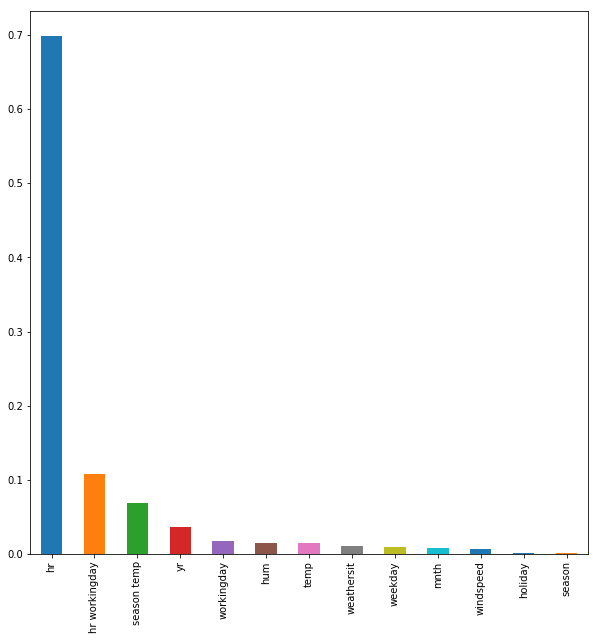

In [481]:
pd.Series(model1_best.feature_importances_, index= X_train_nw_reg.columns).sort_values(ascending=False).plot.bar(figsize=(10,10))

In [487]:
#### casual
inter = PolynomialFeatures(interaction_only=True)

# define bins for stratification
bins = np.linspace(0, 17379, 100)
# Save your Y values in a new ndarray,
# broken down by the bins created above.
y_binned = np.digitize(bikes['cnt'], bins)


#split
X_train_cas, X_test_cas, y_train_cas, y_test_cas = train_test_split(bikes.drop(
                                            columns = ['instant','dteday','cnt','atemp',
                                                       'registered', 'casual']), #X
                                            bikes['casual'], #Y
                                            random_state=123, #seed
                                            stratify=y_binned, #have a representative sample
                                            test_size=0.2) #using 20% for test

y_train_log_cas, y_test_log_cas = np.log1p(y_train_cas), np.log1p(y_test_cas) #get log
X_train_inter_cas = inter.fit_transform(X_train_cas)
X_test_inter_cas = inter.fit_transform(X_test_cas)
X_train_nw_cas = pd.DataFrame(X_train_inter_cas, columns= inter.get_feature_names(X_train_cas.columns))[X_train_cas.columns.append(nw_feat)]
X_test_nw_cas = pd.DataFrame(X_test_inter_cas, columns= inter.get_feature_names(X_test_cas.columns))[X_train_cas.columns.append(nw_feat)]

In [488]:
### train 
model2 = rf_random
model2.fit(X_train_nw_cas, y_train_log_cas)
model2_best = model2.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 33.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 73.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 86.1min finished


In [489]:
y_pred_cas = model2_best.predict(X_test_nw_cas)
print('### registered users model only\n')
reg_metric(y_test_log_cas, y_pred_cas) 
print('################################\n')


### registered users model only

explained variance :0.8915029519034995
MAE :0.366766217167687
MSE : 0.2388383567764315
MeDAE :0.2812310096727174
R^2 : 0.8913854730053276
################################



In [490]:
model2_best


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1400, n_jobs=1,
           oob_score=False, random_state=123, verbose=0, warm_start=False)

In [498]:
#### put reslult together
y_train_cnt = bikes['cnt'].iloc[X_test_cas.index.values]
y_test_cnt = bikes['cnt'].iloc[X_test_cas.index.values]
y_test_log_cnt = np.log1p(y_test_cnt)
y_pred_cnt = np.log1p( np.exp(y_pred_cas) + np.exp(y_pred_reg) - 2 )

print('### Final metrics for cnt\n')
reg_metric(y_test_log_cnt, y_pred_cnt)
print('################################\n')



### Final metrics for cnt

explained variance :0.9514685565715334
MAE :0.2063169286468355
MSE : 0.09814097174474122
MeDAE :0.1304045957209743
R^2 : 0.9514465327025825
################################



In [500]:
rmsle(y_test_log_cnt, y_pred_cnt)

0.29480161395402343

#### Vizualizations of the predicted/true values

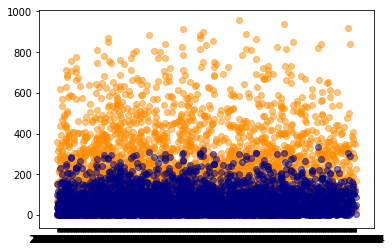

In [519]:
plt.scatter(bikes['dteday'].iloc[X_test_cas.index.values], bikes['cnt'].iloc[X_test_cas.index.values], color = 'darkorange', alpha=0.5)
plt.scatter(bikes['dteday'].iloc[X_test_cas.index.values], np.exp(y_pred_cnt-1), color = 'navy', alpha = 0.5)


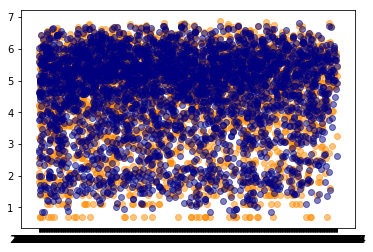

In [520]:
plt.scatter(bikes['dteday'].iloc[X_test_cas.index.values], np.log1p(bikes['cnt'].iloc[X_test_cas.index.values]), color = 'darkorange', alpha=0.5)
plt.scatter(bikes['dteday'].iloc[X_test_cas.index.values], y_pred_cnt, color = 'navy', alpha = 0.5)


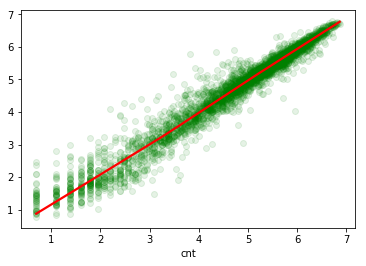

In [621]:
import seaborn as sns
sns.regplot(y_test_log_cnt, y_pred_cnt, color="g", lowess=True, scatter_kws= {'alpha': 0.1}, line_kws={'color': 'red'})

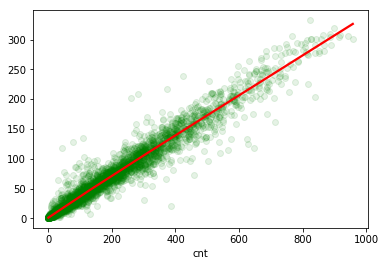

In [622]:
sns.regplot(y_test_cnt, np.exp(y_pred_cnt-1), color="g", lowess=True, scatter_kws= {'alpha': 0.1}, line_kws={'color': 'red'})

In [499]:
print('### Final metrics for cnt non-log\n')
reg_metric(np.exp(y_test_log_cnt)-1, np.exp(y_pred_cnt)-1)
print('################################\n')


### Final metrics for cnt non-log

explained variance :0.9476766409486085
MAE :9.284614174115918
MSE : 238.2552458562929
MeDAE :5.063639118738115
R^2 : 0.9463145275619179
################################



***

### Best model of all 

**best_random** gives best results, further tuning overfits the data as the training error goes down but the test error goes up. 

Additional feature engineering do not imrpove the model.

Fitting the model separately to causal and registered users gives slightly better performance. The prediction of registered users are more accurate than casual users because of numerous outliers among number of bikes rent by casual users. 

95% $R^2$ seems to be the plateau of this dataset.

In [106]:
best_random.fit(X_train, y_train_log)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=60,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=1,
           oob_score=False, random_state=123, verbose=0, warm_start=False)

In [107]:
y_pred = best_random.predict(X_test)

In [108]:
reg_metric(np.exp(y_pred)-1, y_test)

 explained variance :0.9380886102
 MAE :25.0610204990
 MSE :1906.3884424433
 MeDAE :13.5515971338
 R^2 :0.9371111551



In [654]:
import forestci as fci
# Calculate the variance:
mpg_V_IJ_unbiased = fci.random_forest_error(best_random, X_train,X_test)


/usr/local/lib/python3.7/site-packages/forestci/calibration.py:86: RuntimeWarning: overflow encountered in exp
  g_eta_raw = np.exp(np.dot(XX, eta)) * mask


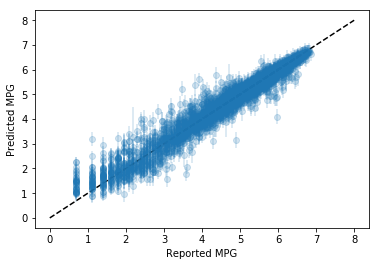

In [660]:
# Calculate the variance:
# Plot error bars for predicted MPG using unbiased variance
plt.errorbar(y_test_log, y_pred, yerr=np.sqrt(mpg_V_IJ_unbiased), fmt='o', alpha = 0.2)
plt.plot([0, 8], [0, 8], 'k--')
plt.xlabel('Reported MPG')
plt.ylabel('Predicted MPG')
plt.show()

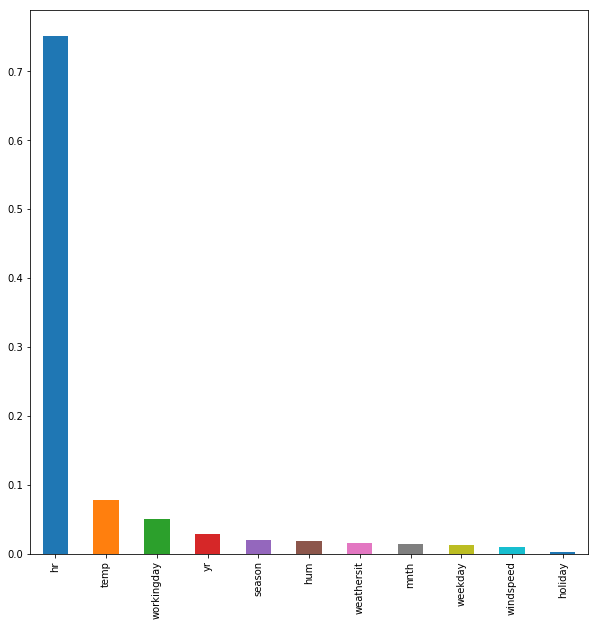

In [109]:
pd.Series(best_random.feature_importances_, index=X_train.columns).sort_values(ascending=False).plot.bar(figsize=(10,10))

### Separately

In [110]:
#### registered
# define bins for stratification
bins = np.linspace(0, 17379, 100)
# Save your Y values in a new ndarray,
# broken down by the bins created above.
y_binned_reg = np.digitize(bikes['registered'], bins)


#split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(bikes.drop(
                                                    columns = ['instant','dteday','cnt','atemp',
                                                               'registered', 'casual']), #X
                                                    bikes['registered'], #Y
                                                    random_state=0, #seed
                                                    stratify=y_binned, #have a representative sample
                                                    test_size=0.2) #using 20% for test
y_train_reg_log, y_test_reg_log = np.log1p(y_train_reg), np.log1p(y_test_reg)
### train
model1=best_random
model1.fit(X_train_reg, y_train_reg_log)
y_pred_reg = model1.predict(X_test_reg)
print('### registered users model only\n')
reg_metric(y_test_reg_log, y_pred_reg) # higher MSE
print('################################\n')


### registered users model only

 explained variance :0.9505230274
 MAE :0.2038984979
 MSE :0.0963229490
 MeDAE :0.1277630871
 R^2 :0.9505222498

################################



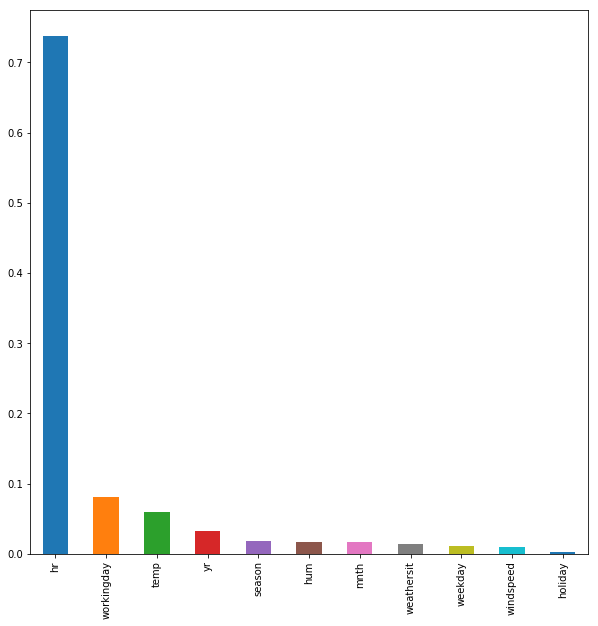

In [111]:
pd.Series(model1.feature_importances_, index=X_train_reg.columns).sort_values(ascending=False).plot.bar(figsize=(10,10))

In [113]:
#### casual
    
# define bins for stratification
bins = np.linspace(0, 17379, 100)
# Save your Y values in a new ndarray,
# broken down by the bins created above.
y_binned_reg = np.digitize(bikes['casual'], bins)


#split
X_train_cas, X_test_cas, y_train_cas, y_test_cas = train_test_split(bikes.drop(
                                                    columns = ['instant','dteday','cnt','atemp',
                                                               'registered', 'casual']), #X
                                                    bikes['casual'], #Y
                                                    random_state=0, #seed
                                                    stratify=y_binned, #have a representative sample
                                                    test_size=0.2) #using 20% for test
y_train_cas_log, y_test_cas_log = np.log1p(y_train_cas), np.log1p(y_test_cas)

### train 
model2 = best_random
model2.fit(X_train_cas, y_train_cas_log)
y_pred_cas = model2.predict(X_test_cas)
print('### casual users model only\n')
reg_metric(y_test_cas_log, y_pred_cas) 
print('################################\n')


### casual users model only

 explained variance :0.8891459787
 MAE :0.3630111560
 MSE :0.2394226092
 MeDAE :0.2705172596
 R^2 :0.8891435043

################################



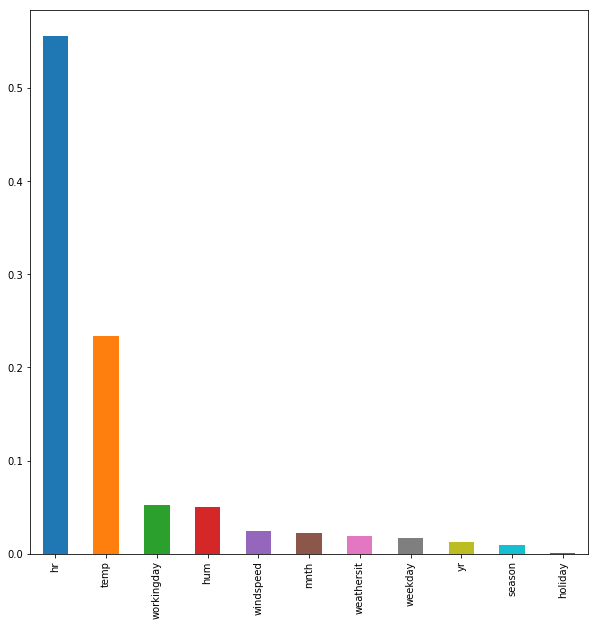

In [114]:
pd.Series(model2.feature_importances_, index=X_train_cas.columns).sort_values(ascending=False).plot.bar(figsize=(10,10))

In [115]:
#### put reslult together
y_train_cnt = bikes.iloc[X_train_cas.index.values, 16]
y_test_cnt = bikes.iloc[X_test_cas.index.values, 16]
y_test_cnt_log = np.log1p(y_test_cnt)
y_pred_cnt = np.log1p(np.exp(y_pred_cas) + np.exp(y_pred_reg) -2)

print('### Final metrics for cnt\n')
reg_metric(y_test_cnt_log, y_pred_cnt)
print('################################\n')

print('### Final metrics for cnt non-log\n')
reg_metric(y_test_cnt, np.exp(y_pred_cnt)-1)
print('################################\n')

### Final metrics for cnt

 explained variance :0.9523630213
 MAE :0.2022789195
 MSE :0.0949594333
 MeDAE :0.1254781286
 R^2 :0.9523225903

################################

### Final metrics for cnt non-log

 explained variance :0.9475522988
 MAE :24.1707695009
 MSE :1770.7838229591
 MeDAE :13.0290194115
 R^2 :0.9462869325

################################



**Comments**

The importance of variables for casual and registered bikes is not the same. In both models hour, temp, and workingday are the most important variables. However, humidity (so rain probably) plays an important role for causal users. Year variable is more important for registered users as the number registered users increased significantly from 2011 to 2012. 

#### Save the best model

In [694]:
# Save the best model into a pickle file.
import pickle
pickle.dump( best_random, open( "best_random_m.p", "wb" ) )

In [79]:
#import pickle
#best_random= pickle.load( open( "best_random_m.p", "rb" ) )

In [696]:
#best_model_import

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=60,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=1,
           oob_score=False, random_state=123, verbose=0, warm_start=False)

### Minimal model

In [680]:
from sklearn.model_selection import train_test_split

# define bins for stratification
bins = np.linspace(0, 17379, 100)
# Save your Y values in a new ndarray,
# broken down by the bins created above.
y_binned = np.digitize(bikes['cnt'], bins)


#split
X_train, X_test, y_train, y_test = train_test_split(bikes['hr'], #X
                                                    bikes['cnt'], #Y
                                                    random_state=123, #seed
                                                    stratify=y_binned, #have a representative sample
                                                    test_size=0.2) #using 20% for test
y_train_log, y_test_log = np.log1p(y_train), np.log1p(y_test) #get log

In [682]:
best_random.fit(np.array(X_train).reshape(-1, 1), y_train_log)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=60,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=1,
           oob_score=False, random_state=123, verbose=0, warm_start=False)

In [684]:
y_pred = best_random.predict(np.array(X_test).reshape(-1, 1))

reg_metric(y_test_log, y_pred) 



explained variance :0.6926796797573287
MAE :0.6125242201507212
MSE : 0.6212307349565693
MeDAE :0.4998711984484996
R^2 : 0.6926573515868957


**Comment** 

Using only hour we can attein 69% $R^2$

### Reduced model

In [685]:
from sklearn.model_selection import train_test_split

# define bins for stratification
bins = np.linspace(0, 17379, 100)
# Save your Y values in a new ndarray,
# broken down by the bins created above.
y_binned = np.digitize(bikes['cnt'], bins)


#split
X_train, X_test, y_train, y_test = train_test_split(bikes[['hr','temp', 'workingday']], #X
                                                    bikes['cnt'], #Y
                                                    random_state=123, #seed
                                                    stratify=y_binned, #have a representative sample
                                                    test_size=0.2) #using 20% for test
y_train_log, y_test_log = np.log1p(y_train), np.log1p(y_test) #get log

In [687]:
best_random.fit(X_train, y_train_log)
y_pred = best_random.predict(X_test)

reg_metric(y_test_log, y_pred) 



explained variance :0.8643660187054829
MAE :0.39144685240440336
MSE : 0.2741890242378428
MeDAE :0.3117190381126673
R^2 : 0.8643499490073445


In [101]:
test_separately_2(best_random, ['hr'])

### registered users model only

 explained variance :0.6913838147
 MAE :0.5997695478
 MSE :0.6008827049
 MeDAE :0.4904826460
 R^2 :0.6913474443

################################

### casual users model only

 explained variance :0.5466008056
 MAE :0.7915271285
 MSE :0.9794616967
 MeDAE :0.6654641012
 R^2 :0.5464935760

################################

### Final metrics for cnt

 explained variance :0.6916002440
 MAE :0.6154799111
 MSE :0.6147443459
 MeDAE :0.5177228310
 R^2 :0.6913480102

################################

### Final metrics for cnt non-log

 explained variance :0.4739368480
 MAE :91.6928486780
 MSE :19130.1618495080
 MeDAE :56.8426228376
 R^2 :0.4197260770

################################



In [100]:
test_separately_2(best_random, ['hr','temp', 'workingday'])

### registered users model only

 explained variance :0.8606281757
 MAE :0.3908485031
 MSE :0.2713759464
 MeDAE :0.3062019484
 R^2 :0.8606036107

################################

### casual users model only

 explained variance :0.8002002989
 MAE :0.4919422719
 MSE :0.4315625812
 MeDAE :0.3856768521
 R^2 :0.8001796256

################################

### Final metrics for cnt

 explained variance :0.8666055103
 MAE :0.3857507337
 MSE :0.2657355658
 MeDAE :0.2980756743
 R^2 :0.8665789906

################################

### Final metrics for cnt non-log

 explained variance :0.7523084622
 MAE :59.1847304073
 MSE :8406.1379415248
 MeDAE :35.0748365642
 R^2 :0.7450171787

################################



In [103]:
test_separately_2(best_random, ['hr','temp', 'workingday','hum'])

### registered users model only

 explained variance :0.8647249312
 MAE :0.3865137397
 MSE :0.2633778255
 MeDAE :0.2959994499
 R^2 :0.8647119674

################################

### casual users model only

 explained variance :0.8076511918
 MAE :0.4868829176
 MSE :0.4155042804
 MeDAE :0.3710153870
 R^2 :0.8076148756

################################

### Final metrics for cnt

 explained variance :0.8725419350
 MAE :0.3781377985
 MSE :0.2539172125
 MeDAE :0.2931967391
 R^2 :0.8725127715

################################

### Final metrics for cnt non-log

 explained variance :0.7724117639
 MAE :56.2964639634
 MSE :7622.7793808267
 MeDAE :33.2834912188
 R^2 :0.7687787417

################################



**Comments** 

With only three variables we can get fairly good prediction accuracy $R^2$ = 87% (76,8% non-log) For a client it can be interesiting to know that to have a rough prediction of the number of bikes needed hour, temperature and day of the week are sufficient. There are variables that are not deificult to collect even a few days before. 

***

***

### Helper functions

In [95]:
#Additional regression metric as defined in the kaggle challenge: Root Mean Squared Logarithmic Error 
#Params: 
#y - true y values from the test sets
#y_- predicted y values
#Value: 
#Returns Root Mean Squared Logarithmic Error 

def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [96]:
#A helper function that fits a model to causal and regisered separately and cobine the score
#Params: 
#model - regression model
#Value:
#Function prints regression metric for models fitted separately to casual and registred and final score

def test_separately(model): 
    #### registered
    # define bins for stratification
    bins = np.linspace(0, 17379, 100)
    # Save your Y values in a new ndarray,
    # broken down by the bins created above.
    y_binned_reg = np.digitize(bikes['registered'], bins)


    #split
    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(bikes.drop(
                                                        columns = ['instant','dteday','cnt','atemp',
                                                                   'registered', 'casual']), #X
                                                        bikes['registered'], #Y
                                                        random_state=0, #seed
                                                        stratify=y_binned, #have a representative sample
                                                        test_size=0.2) #using 20% for test
    y_train_reg_log, y_test_reg_log = np.log1p(y_train_reg), np.log1p(y_test_reg)
    ### train
    model1=model
    model1.fit(X_train_reg, y_train_reg_log)
    y_pred_reg = model1.predict(X_test_reg)
    print('### registered users model only\n')
    reg_metric(y_test_reg_log, y_pred_reg) # higher MSE
    print('################################\n')
    #### casual
    
    # define bins for stratification
    bins = np.linspace(0, 17379, 100)
    # Save your Y values in a new ndarray,
    # broken down by the bins created above.
    y_binned_reg = np.digitize(bikes['casual'], bins)


    #split
    X_train_cas, X_test_cas, y_train_cas, y_test_cas = train_test_split(bikes.drop(
                                                        columns = ['instant','dteday','cnt','atemp',
                                                                   'registered', 'casual']), #X
                                                        bikes['casual'], #Y
                                                        random_state=0, #seed
                                                        stratify=y_binned, #have a representative sample
                                                        test_size=0.2) #using 20% for test
    y_train_cas_log, y_test_cas_log = np.log1p(y_train_cas), np.log1p(y_test_cas)
    
    ### train 
    model2 = model
    model2.fit(X_train_cas, y_train_cas_log)
    y_pred_cas = model2.predict(X_test_cas)
    print('### casual users model only\n')
    reg_metric(y_test_cas_log, y_pred_cas) 
    print('################################\n')
    #### put reslult together
    y_train_cnt = bikes.iloc[X_train_cas.index.values, 16]
    y_test_cnt = bikes.iloc[X_test_cas.index.values, 16]
    y_test_cnt_log = np.log1p(y_test_cnt)
    y_pred_cnt = np.log1p(np.exp(y_pred_cas) + np.exp(y_pred_reg) -2)
    
    print('### Final metrics for cnt\n')
    reg_metric(y_test_cnt_log, y_pred_cnt)
    print('################################\n')
    
    print('### Final metrics for cnt non-log\n')
    reg_metric(y_test_cnt, np.exp(y_pred_cnt)-1)
    print('################################\n')

In [99]:
#A modification of test_seaprately() that allows defining predictor variables
#Params: 
#model - regression model
#predictors - a list of column names to be used as predictors
#Value:
#Function prints regression metric for models fitted separately to casual and registred and final score

def test_separately_2(model, predictors): 
    #### registered
    # define bins for stratification
    bins = np.linspace(0, 17379, 100)
    # Save your Y values in a new ndarray,
    # broken down by the bins created above.
    y_binned_reg = np.digitize(bikes['cnt'], bins)


    #split
    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(bikes[predictors],
                                                        bikes['registered'], #Y
                                                        random_state=0, #seed
                                                        stratify=y_binned, #have a representative sample
                                                        test_size=0.2) #using 20% for test
    y_train_reg_log, y_test_reg_log = np.log1p(y_train_reg), np.log1p(y_test_reg)
    ### train
    model1=model
    model1.fit(X_train_reg, y_train_reg_log)
    y_pred_reg = model1.predict(X_test_reg)
    print('### registered users model only\n')
    reg_metric(y_test_reg_log, y_pred_reg) # higher MSE
    print('################################\n')
    #### casual
    
    # define bins for stratification
    bins = np.linspace(0, 17379, 100)
    # Save your Y values in a new ndarray,
    # broken down by the bins created above.
    y_binned_reg = np.digitize(bikes['cnt'], bins)


    #split
    X_train_cas, X_test_cas, y_train_cas, y_test_cas = train_test_split(bikes[predictors], #X
                                                        bikes['casual'], #Y
                                                        random_state=0, #seed
                                                        stratify=y_binned, #have a representative sample
                                                        test_size=0.2) #using 20% for test
    y_train_cas_log, y_test_cas_log = np.log1p(y_train_cas), np.log1p(y_test_cas)
    
    ### train 
    model2 = model
    model2.fit(X_train_cas, y_train_cas_log)
    y_pred_cas = model2.predict(X_test_cas)
    print('### casual users model only\n')
    reg_metric(y_test_cas_log, y_pred_cas) 
    print('################################\n')
    #### put reslult together
    y_train_cnt = bikes.iloc[X_train_cas.index.values, 16]
    y_test_cnt = bikes.iloc[X_test_cas.index.values, 16]
    y_test_cnt_log = np.log1p(y_test_cnt)
    y_pred_cnt = np.log1p(np.exp(y_pred_cas) + np.exp(y_pred_reg) -2)
    
    print('### Final metrics for cnt\n')
    reg_metric(y_test_cnt_log, y_pred_cnt)
    print('################################\n')
    
    
    print('### Final metrics for cnt non-log\n')
    reg_metric(y_test_cnt, np.exp(y_pred_cnt)-1)
    print('################################\n')

In [98]:
#A helper function computing regression metrics
#Params:
#y_test - true y values from the test sets
#y_pred - predicted y values
#Value:
#Prints regression metrics

from sklearn import metrics
def reg_metric(y_test, y_pred):
    print(' explained variance :%.10f\n'%(metrics.explained_variance_score(y_test, y_pred)), 
          'MAE :%.10f\n'%(metrics.mean_absolute_error(y_test, y_pred)),
          'MSE :%.10f\n'%(metrics.mean_squared_error(y_test, y_pred)),
          'MeDAE :%.10f\n'%(metrics.median_absolute_error(y_test, y_pred)),
          'R^2 :%.10f\n'%(metrics.r2_score(y_test, y_pred))
         )


In [172]:
#A helper function fitting data with outliers removal
#Params:
#n - number of standart deviation to define an outlier
#Value:
#Prints regression metrics

def test_outliers(n): 
    # define bins for stratification
    bins = np.linspace(0, 17379, 100)
    # Save your Y values in a new ndarray,
    # broken down by the bins created above.
    y_binned = np.digitize(bikes['cnt'], bins)


    #split
    X_train, X_test, y_train, y_test = train_test_split(bikes.drop(
                                                        columns = ['instant','dteday','cnt','atemp',
                                                                   'registered', 'casual']), #X
                                                        bikes['cnt'], #Y
                                                        random_state=123, #seed
                                                        stratify=y_binned, #have a representative sample
                                                        test_size=0.2) #using 20% for test
    
    X_train_no = X_train[np.abs(y_train-y_train.mean())<=(n*y_train.std())] 
    y_train_no = y_train[np.abs(y_train-y_train.mean())<=(n*y_train.std())] 
    y_train_log, y_test_log = np.log1p(y_train_no), np.log1p(y_test) #get log
    rf = RandomForestRegressor(random_state=123)
    rf.fit(X_train_no, y_train_log)
    y_pred = rf.predict(X_test)

    reg_metric(y_test_log, y_pred) 
    
